<h1>Searching for MACHOs using the Spectra of Fast Radio Bursts</h1>

Andrey Katz, Joachim Kopp, Sergey Sibiryiakov, Wei Xue<br>
arXiv:1910.XXXXX<br>
jkopp@cern.ch

## Usage Information

<h3>License</h3>

Copyright (C) 2019 Joachim Kopp (jkopp@cern.ch)

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

<h3>Usage notes</h3>

This worksheet simulates scintillation in the IGM/ISM as well as gravitational lensing by ray-tracing the signal from the source to the observer across an arbitrary number of scintillation screens (limited by available memory and CPU power).

Examples for how to use it are given in section "Results".

Important notes:
- <b>Distances are *comoving*</b>. This is different from much of the lensing literature, where angular diameter distances are used. We convert to angular diameter distance where needed
- for <b>unit conversion</b>, use the my_units class, which effectively defines the conversion factors to natural units
- <b>scintillation screens</b> can be 1d or 2d. 2d is more realistic, but usually unfeasible due to memory consumptions. For the lensing calculation, even 1d screens can be extended to 2d. In other words, the scintillation pattern is still 1d, but to carry out the Fresnel integral between two screens that have a gravitational lens between them, the screens are extended to 2d. This is necessary, when the screens are for
from both the observer and the source. If, on the other hand, a scintillation screen is close to either of the two (so that the geometric phase accrued between the screen and the observer/source is small), 1d screens can be used to a very good approximtion.
- the most important parameter for scintillation is x_diff, the <b>diffractive scale</b>. Based on x_diff, the refractive scale x_ref is computed; screens need to be much larger than x_ref, and the resolution needs to be high enough to well resolve x_diff. Smaller x_diff implies larger x_ref, and thus more memory is needed to store the screens. This is usually the limiting factor for ISM screens
- The code gives reliable results only if there are <b>zero or one gravitational lenses</b> along the line of sight.
- The code supports both lensing in the <b>geometric optics</b> regime and in the <b>wave optics</b> regime. The latter, of course, is more computationally expensive.
- <b>GPU acceleration</b> is fully supported (via CUDA / CuPy), and in many cases essential

Citation: if you use this code, please cite the following reference:
Andrey Katz, Joachim Kopp, Sergei Sibiryakov, and Wei Xue, 2019, arXiv:1911:xxxxx

## Initialization

In [6]:
# Run as batch script or as interactive Jupyter notebook?
import sys
if len(sys.argv) >= 1 and sys.argv[1].upper() == "BATCH":
    print("Running in batch mode.")
    batch_mode = 1
    use_gpu    = 1
else:
    print("Running in Jupyter mode.")
    from IPython.display import HTML
    %precision %.4g
    batch_mode = 0
    use_gpu    = 0
    
if use_gpu:
    print("Using GPU acceleration.")
    import numpy as np
    import cupy as cp
    import cupy.random as rnd
    import cupy.fft as fft
    from cupyx.scipy.special import gamma
    from cupyx.scipy.special import j0
    xp = cp
    def get_random_state():
        return rnd.get_random_state()
    def set_random_state(s):
        return rnd.set_random_state(s)
else:
    print("Running on CPU.")
    import numpy as np
    import numpy.random as rnd
    import scipy.fftpack as fft
    from scipy.special import gamma
    from scipy.special import j0
    xp = np
    def get_random_state():
        return rnd.get_state()
    def set_random_state(s):
        return rnd.set_state(s)

def nparray(a):
    if use_gpu and type(a)==cp.ndarray:
        return cp.asnumpy(a)
    else:
        return a

# Standard packages
import os
import re
import time
import pickle
from collections import namedtuple
import numpy.polynomial.polynomial as poly
import scipy.special as sf
import scipy.integrate as integ
import scipy.optimize as opt
import scipy.fftpack as fftpack
import scipy.signal as sig
from scipy.signal import savgol_filter
import math, cmath
import mpmath as mp

# Setup Matplotlib¢
import matplotlib
if batch_mode:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.colors as colors
if not batch_mode:
    %matplotlib inline
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=[r'\usepackage{amsmath,amssymb,siunitx}'])
    plt.rc('font', family='serif')

# Unit conversion and physical constants
class my_units:
    # Energy and mass
    eV    = 1.
    keV   = 1.e3
    MeV   = 1.e6
    GeV   = 1.e9
    TeV   = 1.e12
    PeV   = 1.e15
    kg    = 5.62e35*eV
    grams = 0.001*kg
    
    # Length and time
    m     = 5.076e6
    meter = m
    km    = 1000*m
    cm    = 0.01*m
    nm    = 1.e-9*m
    fm    = 1.e-15*m
    AU    = 1.4960e11*m
    pc    = 30.857e15*m
    kpc   = 1.e3*pc
    Mpc   = 1.e6*pc
    Gpc   = 1.e9*pc
    ly    = 9460730472580800*m  # light year
    sec   = 1.523e15
    hours = 3600*sec
    days  = 24*hours
    yrs   = 365*days,
    Hz    = 1./sec
    kHz   = 1.e3*Hz
    MHz   = 1.e6*Hz
    GHz   = 1.e9*Hz
    
    # Various astrophysical constants
    GN    = 6.708e-39/1e18  # eV^-2, Newton's constant
    MPl   = 1.22093e19*GeV   # Planck mass, PDG 2013
    Msun  = 1.989e30*kg
    Rsun  = 6.9551e8*meter
    
    # cosmology
    h       = 0.6766                         # (Planck 2018)
    H0      = h * 100. * km / sec/ Mpc       # Hubble parameter
    rho_c0  = 3. * H0**2/(8. * np.pi * GN)   # critical density today, Kolb Turner eq. (3.14)
    Omega_m = 0.14240 / h**2                 # total matter density (Placnk 2018)
    Omega_Lambda = 0.6889 / h**2             # dark energy density (Planck 2018)
    
    # particle physics
    alpha_em = (1./137.035999139)            # electromagnetic fine structure constant (PDG 2018)
    m_e      = 0.5109989461 * MeV            # electron mass (PDG 2018)

u = my_units()

# Directory for data files (in particular saved screens)
base_dir     = os.path.expanduser('~/lxplus/cernbox/frb/jk/')
data_dir     = base_dir + '/results/'
plots_dir    = base_dir + '/plots/'
fname_suffix = '-test'       # file name suffix for data files
if not batch_mode:
    os.chdir(base_dir)

# small number used to avoid roundoff problems
eps          = 1e-8

# Default x_diff
x_diff_ism_0 = 2.2e8*u.cm
x_diff_igm_0 = 1e12*u.cm

# Seed random number generator
if batch_mode:
    rnd.seed()                               # seed random number generator with truly random seed
else:
    rnd.seed(120880)

Running in Jupyter mode.
Running on CPU.


In [7]:
# vectorizable implementation of the gamma function
# based on the example given at https://en.wikipedia.org/wiki/Lanczos_approximation
def gamma(z):
    p = [ 676.5203681218851,
        -1259.1392167224028,
          771.32342877765313,
         -176.61502916214059,
           12.507343278686905,
           -0.13857109526572012,
            9.9843695780195716e-6,
            1.5056327351493116e-7 ]
    eps = 1e-07

    Z = z.flatten()
    i1 = xp.nonzero(xp.real(Z) <  0.5)
    i2 = xp.nonzero(xp.real(Z) >= 0.5)
    
    Y = xp.empty(Z.shape, dtype=complex)
    if len(i1[0]) > 0:
        Y[i1] = xp.pi / (xp.sin(xp.pi*Z[i1]) * gamma(1-Z[i1])) # Reflection formula 
    
    if len(i2[0]) > 0:
        Z[i2] -= 1
        X      = 0.99999999999980993
        for (i, pval) in enumerate(p):
            X += pval / (Z[i2]+i+1)
        T = Z[i2] + len(p) - 0.5
        Y[i2] = xp.sqrt(2*xp.pi) * T**(Z[i2]+0.5) * xp.exp(-T) * X
    
    Y.shape = z.shape
    return Y

# My own implementation of some hypergeometric functions and laguerre polynomials, required for vectorized computation
# of lensing in the wave optics regime
# based on the implementation of mpmath.hyp1f1, see function hypsum() in file ctx_fp.py and mpmath.hyp1f1()
# in hypergeometric.py
# see also https://en.wikipedia.org/wiki/Generalized_hypergeometric_function and Johansson's paper
# Hypergeometric 1F1 function computed using series expansion
def hyp1f1_series(a,b,z):
    if len(a) == len(b) == len(z) == 0:  # avoid "mean of empty slice" warning
        return xp.array([])
    s = t = 1.
    for k in xp.arange(6000):
        t *= (a+k) / ((b+k) * (k+1)) * z
        s += t
        if (xp.abs(xp.mean(t)) < sys.float_info.epsilon):
            break
    return s

# Hypergeometric 1F1 function computed by transforming to two 2F0 functions
# using Johansson eqs. (7) and (5), as well as the definition of the regularized hyp1f1 function
def hyp1f1_trafo(a,b,z):
    z_inv = 1./z
    return gamma(b) * ( (-z)**(-a) / gamma(b-a) * hyp2f0_series(a, a-b+1, -z_inv) \
                      + z**(a-b) * xp.exp(z) / gamma(a) * hyp2f0_series(b-a, -a+1, z_inv) )
    
# Hypergeometric 1F1 function
# depending on |z|, the function switches between a series expansion and a transformation to 2F0 functions
def hyp1f1(a, b, z):
    # bring all arrays to the same shape ("broadcasting"), then flatten for subsequent operations
    bc = xp.broadcast(a,b,z)
    A = xp.broadcast_to(a, bc.shape).flatten()
    B = xp.broadcast_to(b, bc.shape).flatten()
    Z = xp.broadcast_to(z, bc.shape).flatten()

    r = xp.empty(Z.shape, dtype=complex)
    i_small_z = xp.nonzero(xp.abs(Z) <  2**6)
    i_large_z = xp.nonzero(xp.abs(Z) >= 2**6)  
    r[i_small_z] = hyp1f1_series(A[i_small_z], B[i_small_z], Z[i_small_z])
    r[i_large_z] = hyp1f1_trafo(A[i_large_z], B[i_large_z], Z[i_large_z])

    r.shape = bc.shape
    return r

# Hypergeometric 2F0 function computed using series expansion
def hyp2f0_series(a1, a2, z):
    if len(a1) == len(a2) == len(z) == 0:  # avoid "mean of empty slice" warning
        return xp.array([])
    s = t = 1.
    for k in xp.arange(6000):
        t *= (a1+k) * (a2+k) / (k+1) * z
        s += t
        if (xp.abs(xp.mean(t)) < sys.float_info.epsilon):
            break
    return s

# Hypergeometric 2F0 function expressed in terms of two 1F1 functions (Johansson eq. (6))
def hyp2f0_trafo(a1, a2, z):
    z_inv = -1./z
    a = a1               # a and b parameters appearing in Johansson eq. (6)
    b = a1 - a2 + 1      # defined based on eq. (5) relating U* and 2F2
    return z_inv**(a) * ( gamma(1-b)/gamma(a-b+1) * hyp1f1_series(a, b, z_inv) \
                        + gamma(b-1)/gamma(a) * z_inv**(1-b) * hyp1f1_series(a-b+1, 2-b, z_inv) )

# Hypergeometric 2F0 function
# depending on |z|, the function switches between a series expansion and a transformation to 2F0 functions
def hyp2f0(a1, a2, z):
    # bring all arrays to the same shape ("broadcasting"), then flatten for subsequent operations
    bc = xp.broadcast(a1,a2,z)
    A1 = xp.broadcast_to(a1, bc.shape).flatten()
    A2 = xp.broadcast_to(a2, bc.shape).flatten()
    Z  = xp.broadcast_to(z, bc.shape).flatten()
    i_small_z = xp.nonzero(xp.abs(Z) <  2**-6)
    i_large_z = xp.nonzero(xp.abs(Z) >= 2**-6)

    r = xp.empty(Z.shape, dtype=complex)
    r[i_small_z] = hyp2f0_series(A1[i_small_z], A2[i_small_z], Z[i_small_z])
    r[i_large_z] = hyp2f0_trafo(A1[i_large_z], A2[i_large_z], Z[i_large_z])
    r.shape = bc.shape
    return r

# Laguerre polynomials
def laguerre(n, z):
    return hyp1f1(-n, xp.array([1.]), z)

## Femtolensing Basics

In [8]:
# conversion between angular diameter distance and redshift
def z_to_dA(z):
    return 1./(1+z)/u.H0 * integ.quad(lambda zz: 1./np.sqrt(u.Omega_m*(1+zz)**3 + u.Omega_Lambda), 0, z)[0]
def dA_to_z(dA):
#    return 0. # FIXME FIXME FIME
    return opt.brentq(lambda z: dA - z_to_dA(z), 0., 1.)
#zrange = np.linspace(0,10, 30)
#plt.plot(zrange, [z_to_dA(z) / u.Gpc for z in zrange])


# Einstein angle (Einstein radius / DL, evaluated using angular diameter distances)
#   DS: comoving distance from the observer to the source
#   DL: comoving distance from the observer to the lens
#   M:  lens mass
#   zL: (optional) redshift of the lens
def thE(DS, DL, M, zL=None):
    if zL == None:
        zL  = dA_to_z(DL)
    DLS = DS - DL
    return np.sqrt(4*u.GN*M*(1+zL)*DLS/(DL*DS))

# Lensing-induced time delay in geometric optics approximation
# https://arxiv.org/abs/astro-ph/0305055
#   DS: comoving distance from the observer to the source
#   DL: comoving distance from the observer to the lens
#   M:  lens mass
#   y:  angular distance between the lens and the (unlensed) source, normalized to theta_E
#   zL: (optional) redshift of the lens
#   x:  (optional) angular position on the lensing screen, normalized to theta_E
def delta_t_lens(DS, DL, M, y, zL=None, x=None):
    DLS     = DS - DL
    theta_E = thE(DS, DL, M, zL)
    if x == None:
        beta    = y * theta_E
        theta_p = 0.5 * (beta + np.sqrt(beta**2 + 4.*theta_E**2))
        theta_m = 0.5 * (beta - np.sqrt(beta**2 + 4.*theta_E**2))
        return np.abs(DL*DS/DLS * ( 0.5*(theta_p - beta)**2 - theta_E**2 * np.log(np.abs(theta_p)) \
                                  - 0.5*(theta_m - beta)**2 + theta_E**2 * np.log(np.abs(theta_m)) ))
    else:
        return DL*DS/DLS * theta_E**2 * ( 0.5*(x-y)*(x-y) - np.log(np.abs(x)) )
    

# Amplification function for point-like lens in geometric optics
# based on https://arxiv.org/abs/1204.2056
# amplitudes of images taken from https://arxiv.org/abs/1204.2056
# see also fresnel-integral.nb
#   DS: comoving distance from the observer to the source
#   DL: comoving distance from the observer to the lens
#   M:  lens mass
#   omega: photon frequency
#   y:  angular distance between the lens and the (unlensed) source, normalized to theta_E
#   zL: (optional) redshift of the lens
def FclPoint(DS, DL, M, omega, y):
    dy = np.sqrt(y**2 + 4)
    x1 = 0.5 * (y + dy)       # positions of images
    x2 = 0.5 * (y - dy)
    A1 = 1./np.sqrt(np.abs(1. - 1./x1**4))  # amplitudes
    A2 = 1./np.sqrt(np.abs(1. - 1./x2**4))
    return A1 * np.exp(1j * omega * delta_t_lens(DS,DL,M,y,zL,x1)) + \
           A2 * np.exp(1j * omega * delta_t_lens(DS,DL,M,y,zL,x2) - 0.5j*np.pi)
    
# Amplification function for point lenses in wave optics - based on Wei's notebook
#   DS:    comoving distance from the observer to the source
#   DL:    comoving distance from the observer to the lens
#   M:     lens mass
#   omega: photon frequency
#   y:     angular distance between the lens and the (unlensed) source, normalized to theta_E
#   zL:    (optional) redshift of the lens
def FanaPoint(DS, DL, M, omega, y, zL=None):
    DLS     = DS - DL
    theta_E = thE(DS, DL, M, zL)
    c       = omega * DL * DS / DLS * theta_E**2
    return -0.5j * c * (-0.5j*c)**(0.5j*c) * sf.gamma(-0.5j*c) * mp.fp.laguerre(-0.5j*c, 0, 0.5j * c * y**2)

# Amplification function for a range of y and omega values. Switches automatically between geometric optics and wave optics
#   DS:          comoving distance from the observer to the source
#   DL:          comoving distance from the observer to the lens
#   M:           lens mass
#   omega_range: array of photon frequency
#   y_range:     array of angular distances between the lens and the (unlensed) source, normalized to theta_E
#   zL:          (optional) redshift of the lens
def FPoint_vectorized(DS, DL, M, omega_range, y_range, zL=None, method="vectorized"):
    y_shape = y_range.shape      # remember shape of y_range to adjust output array accordingly (internally, we always work with 2d screens)
    DLS     = DS - DL
    theta_E = thE(DS, DL, M, zL)
        
    # for the internal computations, we always work with 2d screens
    y_range = y_range.reshape((len(y_range),-1))

    # compute classical time delay see e.g. https://arxiv.org/abs/1807.11495
    beta_table    = y_range * theta_E
    theta_p_table = 0.5 * (beta_table + xp.sqrt(beta_table**2 + 4.*theta_E**2))
    theta_m_table = -theta_p_table + beta_table
    t_classical_table_p = DL*DS/DLS * ( 0.5*(theta_p_table - beta_table)**2 - theta_E**2 * xp.log(xp.abs(theta_p_table)) )
    t_classical_table_m = DL*DS/DLS * ( 0.5*(theta_m_table - beta_table)**2 - theta_E**2 * xp.log(xp.abs(theta_m_table)) )

    # compute magnification of each image, https://arxiv.org/abs/1204.2056
    A_p_table = xp.where(theta_p_table >  theta_E, 1./xp.sqrt(xp.abs(1. - theta_E**4/theta_p_table**4)), 0.)  # amplitudes
    A_m_table = xp.where(theta_m_table > -theta_E, 1./xp.sqrt(xp.abs(1. - theta_E**4/theta_m_table**4)), 0.)
    phi_lens_table_geom = A_p_table[:,:,None] * xp.exp(1j * omega_range[None,None,:] * t_classical_table_p[:,:,None]) \
                        + A_m_table[:,:,None] * xp.exp(1j * omega_range[None,None,:] * t_classical_table_m[:,:,None] - 0.5j*np.pi)
    
    # if we can use geometric optics, return geometric optics result
    if xp.min(omega_range) * DL*DS/DLS * theta_E**2 > 10.:
        result = phi_lens_table_geom
    
    # if not: use wave optics calculation where it is stable (first few wiggles),
    # use geometric optics approximation for the higher order wiggles, where it is usually sufficient
    else:
        # make a plot to show the (empirically determined) region where mp.fp.laguerre becomes unstable
#        cc = np.arange(0,25,0.1)
#        yy = np.arange(0,5,0.1)
#        XX = np.array([[np.abs(mp.fp.laguerre(-0.5j*c, 0, 1.j*c*y**2)) for c in cc] for y in yy])
#        plt.plot(cc, 20/(cc+3), c='red')
#        plt.contour(cc, yy, XX, levels=np.arange(-2,2,0.05))
#        plt.xlabel('c')
#        plt.ylabel('y')
#        plt.ylim(min(yy),max(yy))
#        plt.show()

        c_table     = omega_range * DL * DS / DLS * theta_E**2
        gamma_table = xp.asarray( sf.gamma(-0.5j*nparray(c_table)) )    # CuPy doesn't support complex gamma functions -> always evaluate on CPU
        z_table     = c_table[None,None,:] * y_range[:,:,None]**2

        # determine the parameter range in which we have to fall back to geometric optics because mp.fp.laguerre becomes unstable
        stability_cond = y_range[:,:,None] < 20./(c_table[None,None,:]+3)

        if method == "mpmath":
            L_table = xp.array([[mp.fp.laguerre(-0.5j*c, 0, 0.5j*c*y**2) for c in c_table ] for y in y_range])
        else:
            with np.errstate(over="ignore", invalid="ignore"):
                L_table = laguerre(-0.5j*c_table[None,None,:], 0.5j * z_table)
#            for i in zip(*xp.where(((xp.abs(z_table) > 40.) & stability_cond))): # fall back to mpmath if argument to laguerre is too large for series expansion
#                L_table[i] = mp.fp.laguerre(-0.5j*c_table[i[2]], 0, 0.5j*z_table[i])
        phi_lens_table_wave = -0.5j * c_table[None,None,:] * (-0.5j*c_table[None,None,:])**(0.5j*c_table[None,None,:]) * gamma_table[None,None,:] * L_table

        # where laguerre is stable, use wave optics calculation, where it is unstable, use geometric optics
        # for reasons unknown to me, cupy.where works only on real arrays, therefore we treat the real and imaginary parts separately here
        result =      xp.where(stability_cond, xp.real(phi_lens_table_wave), xp.real(phi_lens_table_geom)) \
               + 1j * xp.where(stability_cond, xp.imag(phi_lens_table_wave), xp.imag(phi_lens_table_geom))
        
    # return result, reshaped to match the shape of the input y_range
    return xp.reshape(result, tuple(list(y_shape) + list(omega_range.shape)))

# A wrapper for FPoint_vectorized that un-vectorizes in omega
def FPoint_partially_vectorized(DS, DL, M, omega_range, y_range, zL=None, method="vectorized"):
    return xp.concatenate(tuple([ FPoint_vectorized(DS, DL, M, w, y_range, zL=zL, method=method) for w in omega_range[:,None] ]), axis=-1)

In [47]:
#omega_range=np.array([5100.])*u.MHz
#XX=FPoint_vectorized(1.*u.Gpc, 0.5*u.Gpc, 0.0001*u.Msun, omega_range[:], np.array([-26]), method="vectorized")
#YY=FPoint_partially_vectorized(1.*u.Gpc, 0.5*u.Gpc, 0.0001*u.Msun, omega_range[:], np.array([-26]), method="vectorized")
#print(XX)
#print(YY)

## Analysis routines

The following analysis could be improved by using e.g. elastic net regression for the sideband fit

In [9]:
# function for finding peaks in the FFT of the power spectrum
# -----------------------------------------------------------
def peak_finder(t_range_fft, pspect_fft):
    n_roi  = len(pspect_fft)//20   # area around the peak to consider
    widths = list(set([  max(1,n_roi//x) for x in [2,4,8,16,32] ])) # peak widths to test
    sigma  = np.zeros((len(pspect_fft), len(widths)))
    for j in range(len(pspect_fft)):
        j_range           = range(max(0, j-n_roi//2), min(len(pspect_fft), j+n_roi-n_roi//2))   # current region of interest
        for k, w in enumerate(widths):
            j_range_peak      = range(max(0, j-w//2), min(len(pspect_fft), j+w-w//2))
            j_range_sidebands = sorted(list(set(j_range) - set(j_range_peak)))
            x_peak            = t_range_fft[j_range_peak]
            x_sidebands       = t_range_fft[j_range_sidebands]
            y_peak            = pspect_fft[j_range_peak]
            y_sidebands       = pspect_fft[j_range_sidebands]
        
            # do polynomial fit in the area around the peak position
            popt, pcov = opt.curve_fit(lambda x, a0, a1, a2, a3: poly.polyval(x, [a0,a1,a2,a3]), x_sidebands, np.log10(y_sidebands), p0=(1.,1.,1.,1.))
            sigma[j,k] = np.sum(y_peak - 10**poly.polyval(x_peak, popt)) / len(x_peak) \
                           / np.std(y_sidebands - 10**poly.polyval(x_sidebands, popt))

#            if w > 4 and -3.*dt_lens < t_range_fft[j] < 3.*dt_lens:
#                plt.plot(t_range_fft/u.sec, np.log10(pspect_fft), c='black')
#                plt.plot(x_sidebands/u.sec, poly.polyval(x_sidebands, popt), c='blue', ls=':')
#                plt.plot(x_peak/u.sec, poly.polyval(x_peak, popt), c='red')
#                plt.gca().ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
#                plt.xlabel("Time Delay [sec]")
#                plt.xlim(-3.*dt_lens/u.sec, 3.*dt_lens/u.sec)
#                plt.show()

    return sigma


# Function to analyze and plot a propagated FRB spectrum
# ------------------------------------------------------
def frb_analysis(run_summary, plot_file=None, ):
    M           = run_summary['M']
    x_diff_ism  = run_summary['x_diff_ism']
    try:
        x_diff_igm  = run_summary['x_diff_igm']
    except KeyError:
        x_diff_igm  = np.nan
    DS              = run_summary['DS']
    DL              = run_summary['DL']
    DLS             = run_summary['DLS']
    zL              = run_summary['zL']
    y               = run_summary['y']
    Dsc             = run_summary['Dsc']
    spect_table_out = run_summary['spect_table']
    try:
        spect_table_in = run_summary['spect_table_in'].flatten()
    except KeyError:
        spect_table_in = sig_spect(run_summary['omega_range'])
    omega_range     = run_summary['omega_range']
    spect_table     = spect_table_out
    domega          = (omega_range[-1] - omega_range[0]) / (len(omega_range) - 1)
    
    # Calculate expected lensing signal
    dt_lens     = delta_t_lens(DS, DL, M, y)
    
    # calculate characteristic scintillation time delay
    x_ref       = Dsc / (np.mean(omega_range) * x_diff_ism)
    dt_scint    = x_ref**2 / (2. * Dsc)

    # Apply low-pass filter
#    f_range      = omega_range / (2.*np.pi)
#    f_range_corr = f_range - f_range[0]
#    spect_corr   = np.array([ np.abs(np.mean(np.conj(spect_table) * np.roll(spect_table, n))) for n in range(len(omega_range)) ]) \
#                     / np.mean(np.abs(spect_table)**2)  # Determine decorrelation bandwith
#    f_decorr = f_range_corr[np.where(spect_corr < 0.5)]
#    Wn_lowpass = (f_decorr[0] - f_range_corr[0]) / (f_range_corr[-1] - f_range_corr[0])
#    b, a = sig.butter(10, Wn_lowpass, btype='lowpass')
#    spect_table = sig.lfilter(b, a, np.abs(spect_table)**2)
    
    # power spectrum
    # --------------
    f_range = omega_range / (2.*np.pi)
    plt.figure(figsize=(15,4))
    plt.rc('font', size = 16)
    ax = plt.subplot(131)
    ax.plot(f_range[:]/u.MHz, np.abs(spect_table/spect_table_in)**2)
    ax.set_xlabel("frequency [MHz]")
    ax.set_ylabel("observed / source power spectrum [A.U.]")
#    ax.set_ylim(0.5*min(np.min(np.abs(spect_table)**2), spect_table_in[0]**2),
#                2.*max(np.max(np.abs(spect_table)**2), spect_table_in[-1]**2))
#    ax.set_yscale("log")
    ax.set_title("Power Spectrum")
    my_labels = "$M$ = {:5.2g} $M_\\odot$\n".format(M/u.Msun)
    if not np.isnan(x_diff_ism):
        my_labels = my_labels + "$x_{{diff}}^{{ism}}$ = {:5.2g} cm\n".format(x_diff_ism/u.cm)
    if not np.isnan(x_diff_igm):
        my_labels = my_labels + "$x_{{diff}}^{{igm}}$ = {:5.2g} cm\n".format(x_diff_igm/u.cm)
    my_labels = my_labels + "$df_{{lens}}$ = {:5.2g} MHz\n".format(1./dt_lens / u.MHz)
    my_labels = my_labels + "$\\Delta t_{{scint}}$ = {:5.2g} sec".format(dt_scint / u.sec)
    ax.annotate(my_labels, (0.98,0.98), xycoords='axes fraction', ha='right', va='top')

    # FIXME FIXME
#     ss = np.abs(spect_table/spect_table_in)**2
#     f_fit_0  = lambda f, a0, a1, a2, a3: poly.polyval(f, [a0,a1,a2,a3])
#     f_fit_1  = lambda f, a0, a1, a2, a3, A, phi: A*np.cos(2.*np.pi*dt_lens*f + phi) + poly.polyval(f, [a0,a1,a2,a3])
#     startval = np.mean(ss) / np.mean(f_range)**np.arange(3,-1,-1)
#     popt_0, pcov_0 = opt.curve_fit(f_fit_0, f_range, ss, p0=startval, method='lm')
#     popt_1, pcov_1 = opt.curve_fit(f_fit_1, f_range, ss, p0=(*startval, np.mean(ss), np.pi), method='lm')
#     ax.plot(f_range/u.MHz, f_fit_0(f_range, *popt_0), color='red')
#     ax.plot(f_range/u.MHz, f_fit_1(f_range, *popt_1), color='green')
    

    # autocorrelation
    # ---------------
    ax = plt.subplot(132)
    f_range_corr = f_range - f_range[0]
    spect_corr   = np.array([ np.abs(np.mean(np.conj(spect_table) * np.roll(spect_table, n))) for n in range(len(omega_range)) ]) \
                         / np.mean(np.abs(spect_table)**2)
    ax.plot(f_range_corr/u.MHz, spect_corr)
#    ax.set_xlim(0., f_range_corr[100]/u.MHz)
    ax.grid(which='both')
    ax.set_xlabel("Frequency Shift [MHz]")
    ax.set_title("Autocorrelation")
    f_decorr = f_range_corr[np.where(spect_corr < 0.5)]
    if len(f_decorr) > 0:
        f_decorr = f_decorr[0]
    else:
        f_decorr = 0.0
        
    # Fit with and without oscillation
#    f_fit_0  = lambda f, a0, a1, a2, a3: poly.polyval(f, [a0,a1,a2,a3])
#    f_fit_1  = lambda f, a0, a1, a2, a3, A, phi: A*np.cos(2.*np.pi*dt_lens*f + phi) + poly.polyval(f, [a0,a1,a2,a3])
#    startval = np.mean(spect_corr) / np.mean(f_range_corr)**np.arange(3,-1,-1)
#    popt_0, pcov_0 = opt.curve_fit(f_fit_0, f_range_corr, spect_corr, p0=startval, method='lm')
#    popt_1, pcov_1 = opt.curve_fit(f_fit_1, f_range_corr, spect_corr, p0=(*startval, np.mean(spect_corr), np.pi), method='lm')
#    ax.plot(f_range_corr/u.MHz, f_fit_0(f_range_corr, *popt_0), color='red')
#    ax.plot(f_range_corr/u.MHz, f_fit_1(f_range_corr, *popt_1), color='green')
    
    # FFT of power spectrum
    # ---------------------
    dt_fft      = 2.*np.pi / (domega * len(omega_range))
    t_range_fft = np.arange(-2*np.pi/(2*domega), 2*np.pi*(1-eps)/(2*domega), dt_fft)    
    pspect_fft  = np.roll( np.abs(fftpack.fft(np.abs(spect_table)**2)), len(t_range_fft)//2 )

    # Find peaks in FFT of power spectrum
    sigma_threshold = 5.
    sigma = np.full(len(t_range_fft), 0.) # FIXME FIXME
#    sigma = np.amax(peak_finder(t_range_fft,pspect_fft), axis=1)
    i_lens_1 = np.argsort(np.abs(t_range_fft - dt_lens))[0] # indices at which the lensing peak is expected
    i_lens_2 = np.argsort(np.abs(t_range_fft + dt_lens))[0]

    ax = plt.subplot(133)
    for t in t_range_fft[np.where(sigma > sigma_threshold)]:
        ax.axvline(x=t/u.sec, linestyle=':', color='red', linewidth=0.5)
    ax.plot(t_range_fft/u.sec, np.log10(pspect_fft))        
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
    ax.set_xlabel("Time Delay [sec]")
    ax.set_xlim(-0.*dt_lens/u.sec, 3.*dt_lens/u.sec)
    ax.set_title("FFT of Power Spectrum")
    sys.stdout.write("M={:5.2e} Msun, x_diff={:5.2e} cm: f_decorr={:7.4g} MHz".format(M/u.Msun, x_diff_ism/u.cm, f_decorr/u.MHz))
    try:
        sigma_lens = max(sigma[np.r_[i_lens_1-1:i_lens_1+2,i_lens_2-1:i_lens_2+2]])
        ax.axvline(x= dt_lens / u.sec, linestyle=':', color='black', linewidth=2)
        ax.axvline(x=-dt_lens / u.sec, linestyle=':', color='black', linewidth=2)
        run_summary['sigma_lens'] = sigma_lens
        ax.annotate("$\\sigma_{{lens}}$ = {:5.2g}".format(sigma_lens),
                    (0.98,0.98), xycoords='axes fraction', ha='right', va='top')
        sys.stdout.write(", sigma={:g}".format(sigma_lens))
    except IndexError:  # if the lensing modulation does not fit within the spectral range, we cannot extract it
        pass
    sys.stdout.write("\n")
#    ax.axvline(x= delta_t_lens(DS, DL, M, y*rE(0.75*u.Gpc,DL-0.25*u.Gpc,M) / rE(DS,DL,M))
#               / u.sec, linestyle=':', color='green', linewidth=2) # FIXME

    if plot_file != None:
        plt.savefig(plot_file, bbox_inches='tight')
        plt.show()
    else:
        plt.show()
    plt.close()
    
    # check distribution of lensing-induced fluctuations - should be exponential
#    plt.hist(np.abs(spect_table/spect_table_in)**2, bins=np.linspace(0, np.max(spect_table/spect_table_in)**2, 20))
#    plt.show()

## Scintillation

In [55]:
# ---------------------------------------------------------------------------------------------------
# Propagate signal to new screen, taking into account geometric factors
# as well as the contribution of the new scintillation screen.
# ---------------------------------------------------------------------------------------------------

# Data type describing various types of "screens" (scintillation, lensing, etc.)
#   x_range:     list of coordinates on the screen
#   omega_range: frequency range
#   spect_table: signal amplitude as a function of x and omega
#   DOsc:        distance from the screen to the observer
#   DSsc:        distance from the source to this screen
#   type:        'sum' for discrete screens, 'int' for continuous screens
# the class also supports an element scint_spect, where the Fourier representation of a
# scintillation screen can be stored
class Screen(object):
    # default constructor
    def __init__(self, x_range, omega_range, spect_table, type, DOsc, DSsc=0.):
        self.x_range     = x_range
        self.omega_range = omega_range
        self.spect_table = spect_table
        self.scint_spect = xp.array([])
        self.DOsc        = DOsc
        self.DSsc        = DSsc
        self.type        = type
            
# Group velocity in ionized plamsa (ISM / IGM)
def delta_vg(n_e, omega):
    omega_p = np.sqrt(4 * np.pi * u.alpha_em * n_e / u.m_e)
    return -omega_p**2 / (2.*omega**2)

# refractive index of ionized plasma (ISM / IGM)
def n_ISM(n_e, omega):
    omega_p = np.sqrt(4 * np.pi * u.alpha_em * n_e / u.m_e)
    return np.sqrt(1 - omega_p**2 / omega**2)
          # Burke, Graham-Smith: "Radio Astronomy", see http://www.cambridge.org/ch/download_file/158926/


# Generic function for evolution between two pre-computed screens, possible taking into account a lens in between
# ---------------------------------------------------------------------------------------------------------------
def evolve_to_screen(screen_in,                # input screen
                     x_range_out,              # coordinates of sampling points on the new screen [1d array]
                     D,                        # distance to the new screen
                     n_e_prop,                 # e- density in the medium between the two screens
                     phi_screen_table,         # phase factors associated with the new screen [2d array of dim (x_range_out, screen_in.omega_range)]
                     type_out="unknown",       # type of output screen ('int' [continuous x] or 'sum' [discrete x])
                     verbose=True,             # print information about the screen
                     
                     # the following arguments are relevants if there's a gravitational lens between the two screens:
                     DL=None,                  # distance from the new screen to the lens
                     M=None,                   # lens mass
                     rL=None,                  # distance of the lens from the line of sight
                     omega_0=None,             # the average \omega (used where averages are OK) - useful when calling for just a slice of omega_range
                     lensing="2d"              # "2d": extend the screen to 2d for the lensing calculation.
                                               # "1d": do not extend the screen. This is valid only if the screen is close to the source or the observer
                    ):

    # some abbreviations
    if omega_0 == None:
        omega_0 = float(xp.mean(omega_range))  # arbitrary reference frequency at which the phase shift is normalized
    omega_range      = screen_in.omega_range
    omega_p          = np.sqrt(4 * np.pi * u.alpha_em * n_e_prop / u.m_e)  # plasma frequency (for dispersion)
    omega_range_disp = omega_range * (1. - 0.5*omega_p**2/omega_range**2)  # omega including dispersion factor
    x_range_in       = screen_in.x_range
    x_in_min         = min(x_range_in)
    x_in_max         = max(x_range_in)
    x_out_max        = max(x_range_out)
    x_out_min        = min(x_range_out)
    spect_table_in   = screen_in.spect_table
    DSsc_in          = screen_in.DSsc
    DOsc_in          = screen_in.DOsc
    DSsc_out         = DSsc_in + D
    DOsc_out         = DOsc_in - D
    if DOsc_out < 0.:
        print("evolve_to_screen: invalid stacking of screens (DOsc_out = {:e} < 0)".format(DOsc_out))
        raise ValueError
    
    # determine dimensionality of screens
    if len(phi_screen_table.shape) == 2  and  len(screen_in.spect_table.shape) == 2:     # 1D screens
        dim = 1
    elif len(phi_screen_table.shape) == 3  and  len(screen_in.spect_table.shape) == 3:   # 2d screens
        dim = 2
    else:
        print("evolve_to_screen: invalid shape of screen array: ", phi_screen_table.shape, " and ", screen_in.spect_table.shape)
        return None
    
    # if including lensing, print characteristics of lensing screen
    if DL != None  or  M != None  or  rL != None:
        if DL==None or M==None or rL==None:
            print("ERROR: incompletely defined lens. Aborting")
            return None
        
        DS      = D                      # Note: in this function, DS and DL are taken relative to the two screens,
        DLS     = DS - DL                #       not relative to the observer and the source ...
        zL      = dA_to_z(DOsc_out + DL) #       ... while the redshift is the real redshift (measured from the observer)
        theta_E = thE(DS, DL, M, zL=zL)
        beta    = rL / DL
        y       = beta / theta_E

        # Compute classical time delay see e.g. https://arxiv.org/abs/1807.11495
        theta_p = 0.5 * (beta + np.sqrt(beta**2 + 4.*theta_E**2))
        theta_m = 0.5 * (beta - np.sqrt(beta**2 + 4.*theta_E**2))
        delta_t_classical = DL*DS/DLS * ( 0.5*(theta_p - beta)**2 - theta_E**2 * np.log(np.abs(theta_p)) \
                                        - 0.5*(theta_m - beta)**2 + theta_E**2 * np.log(np.abs(theta_m)) )
        delta_t_geom      = 0.5 * DL*DS/DLS * ( (theta_p - beta)**2 - (theta_m - beta)**2 )
        dOmega            = 1. / ( 0.5*y*np.sqrt(y**2 + 4) + np.log(np.abs((y + np.sqrt(y**2 + 4)) / (y - np.sqrt(y**2 + 4)))) ) # not used
        df_lens           = dOmega / ( DS*DL/DLS * theta_E**2 )                                                         # not used
        if verbose:
            if xp.min(omega_range) * DL*DS/DLS * theta_E**2 > 10.:
                print("evolve_to_screen: simulating gravitational lens (geometric optics):")
            else:
                print("evolve_to_screen: simulating gravitational lens (wave optics):")
            print("  M                    = {:7.4e} Msun".format(M / u.Msun))
            print("  DS                   = {:7.4e} Gpc".format(DS/u.Gpc))
            print("  DL                   = {:7.4e} Gpc".format(DL/u.Gpc))
            print("  zL                   = {:7.4e}".format(zL))
            print("  rL                   = {:7.4e} cm (local y={})".format(rL/u.cm, y))
            print("  Einstein radius      = {:7.4e} cm".format(theta_E * DL/(1+zL)/u.cm))
            print("  classical time delay = {:7.4e} sec [= {:7.4} MHz]".format(-delta_t_classical/u.sec, -1./delta_t_classical/u.MHz))
            print("  geometric time delay = {:7.4e} sec".format(-delta_t_geom/u.sec))

    # size of grid cells
    if len(x_range_in) > 1:
        dx = xp.mean(x_range_in[1:] - x_range_in[:-1])
    else:
        dx = 1.

    # evolution between 1D screens
    if dim == 1:
        c_reg = 25.  # Parameter of regularizing exponential in coordinate space (for dy-integral)
        
        # If there is a gravitational lens between the two screens, do the following:
        # 1. expand both screens to 2d (otherwise, lensing cannot be simulated)
        # 2. Build lookup table for the lensing-induced phase factors.
        #    we determine the maximum angle between the lens and the (unlensed) source and then sample this
        #    theta range sufficiently finely to resolve the corresponding maximum time delay dt to an accuracy
        #    better than the inverse photon frequency.
        ny_in = ny_out = 1
        if DL != None  and  lensing == "2d":
            # determine range of y-coordinates (orthogonal to the screens).
            x_F_in      = np.sqrt(min(DSsc_in, D) / omega_0)
            y_max_in    = min(2**6*x_F_in, 2.*max(x_range_in))  # factor 2 since x_range runs from -0.5*x_max to 0.5*x_max
            ny_in       = min(2**10, len(x_range_in))
            dy_in       = y_max_in / (ny_in - 1)  if ny_in > 1  else  1.
            if ny_in > 1:                                       # save some time by only using at one half-plane in y-direction
                y_range_in = xp.linspace(0., 0.5*y_max_in, ny_in//2)
            else:
                y_range_in = xp.linspace(-0.5*y_max_in, 0.5*y_max_in, ny_in)
                
            x_F_out     = np.sqrt(min(DOsc_out, D) / omega_0)
            y_max_out   = min(2**6*x_F_out, 2.*max(x_range_out))
            ny_out      = min(2**10, len(x_range_out))
            dy_out      = y_max_out / (ny_out - 1)  if ny_out > 1  else 1.
            y_range_out = xp.linspace(-0.5*y_max_out, 0.5*y_max_out, ny_out)
            if ny_in == 1  and  ny_out > 1:
                y_range_out = xp.linspace(0., 0.5*y_max_out, ny_out//2)
            else:
                y_range_out = xp.linspace(-0.5*y_max_out, 0.5*y_max_out, ny_out)
            
            beta_max    = xp.sqrt(xp.max(rL - (x_range_in[:,None]*DL + x_range_out[None,:]*DLS)/DS)**2
                                + xp.max(     (y_range_in[:,None]*DL + y_range_out[None,:]*DLS)/DS)**2) / DL
            beta_range  = xp.linspace(0., beta_max*(1+eps),
                                      int(2**5 * 2**np.round(np.log2(omega_0*delta_t_lens(DS,DL,M,beta_max/theta_E,zL=zL)))))
            
            print("evolve_to_screen: expanding screen to 2d for lensing calculation.")
            print("                         in               out")
            print("  x_F                = {:7.4e} cm    {:7.4e} cm".format(x_F_in/u.cm, x_F_out/u.cm))
            print("  y_max              = {:7.4e} cm    {:7.4e} cm".format(y_max_in, y_max_out))
            print("  ny                 = {:7.4e}       {:7.4e}".format(ny_in, ny_out))
            print("  beta_max / theta_E = {:7.4e}".format(float(beta_max/theta_E)))
            print("  len(beta_range)    = {:7.4e}".format(len(beta_range)))
            phi_lens_lookup_table = FPoint_vectorized(DS, DL, M, omega_range_disp, beta_range/theta_E, zL=zL)
            print("Done generating lensing lookup table.")

        # Partly vectorized treament to save memory
        # the geometric phase is computed for every pixel on the larger screen, but when looping over the
        # smaller screen, we update the geometric phase only when it has changed significantly
        spect_table_out  = xp.zeros(x_range_out.shape + omega_range.shape) + 0.j
        dphi_geom        = sys.float_info.max
        if (x_in_max - x_in_min > x_out_max - x_out_min): # input screen is larger
            # integral in the x-direction (along the screen)
            for j, x in enumerate(x_range_out):
                if (dphi_geom > np.pi/10.): # did the geometric phase change significantly since we last computed it?
                    delta_x_range = x_range_in - x
                    if screen_in.type == 'sum':
                        phi_geom_table = xp.exp(1j * omega_range_disp[None,:] * 0.5 * delta_x_range[:,None]**2 / D)
                    else:
                        phi_geom_table = xp.exp(1j * omega_range_disp[None,:] * 0.5 * delta_x_range[:,None]**2 / D) \
                                          * xp.where(delta_x_range[:,None] == 0., 1.,
                                              xp.sin(0.5 * omega_range_disp[None,:] * dx * delta_x_range[:,None] / D) \
                                                  / (0.5 * omega_range_disp[None,:] * dx * delta_x_range[:,None] / D))
                                            # integrate geometric phase over interval of size dx, see frb.nb
                                            # divide by dx as this factor is included later
                    
                    last_x = x
                    if DL == None:         # no lensing
                        phi_0 = xp.sum(spect_table_in * phi_geom_table, axis=0)
                    elif lensing == "2d":  # lensing 2d
                        phi_lens_table = xp.full((len(x_range_in),len(y_range_in),len(omega_range_disp)), 0.+0.j)
                        for y in y_range_out:
                            delta_y_range   = y_range_in - y
                            phi_geom_y      = xp.exp(1j * omega_range_disp[None,:] * 0.5
                                                        * ( (y_range_in[:,None]**2/DSsc_in if DSsc_in  > 0. else 0.)
                                                          + (y**2/DOsc_out                 if DOsc_out > 0. else 0.)
                                                          + delta_y_range[:,None]**2/D ) 
                                                   - (y**2/(2.*c_reg**2*x_F_out**2)                 if x_F_out > 0. else 0.)
                                                   - (y_range_in[:,None]**2/(2.*c_reg**2*x_F_in**2) if x_F_in  > 0. else 0.) )
                            beta_table      = xp.sqrt((rL - (x_range_in[:,None]*DL + x*DLS)/DS)**2 + ((y_range_in[None,:]*DL + y*DLS)/DS)**2) / DL
                            i_table         = xp.rint(xp.abs((len(phi_lens_lookup_table)-1) * beta_table / beta_max)).astype('uint')
                            phi_lens_table += phi_geom_y[None,:,:] * phi_lens_lookup_table[i_table]
                        phi_lens_table = xp.sum(phi_lens_table, axis=1)  # Fresnel integral in y direction
                        phi_0          = xp.sum(spect_table_in * phi_geom_table * phi_lens_table, axis=0)
                    elif lensing == "1d":  # lensing 1d
                        phi_lens_table = FPoint_partially_vectorized(DS, DL, M, omega_range_disp, \
                                                                     xp.abs(rL - (x_range_in*DL + x*DLS)/DS) / DL / theta_E, zL=zL)
                        phi_0          = xp.sum(spect_table_in * phi_geom_table * phi_lens_table, axis=0)
                    else:
                        print("evolve_to_screen: invalid value: lensing =", lensing)

                dphi_geom = omega_0 * (1.-0.5*omega_p**2/omega_0**2) * np.abs(x-last_x) * xp.max(xp.abs(delta_x_range)) / D
                spect_table_out[j] = phi_0 * phi_screen_table[j]
                
        else:                                             # output screen is larger
            for j, s, x in zip(range(len(x_range_in)), spect_table_in, x_range_in):                
                if (dphi_geom > np.pi/10.): # did the geometric phase change significantly since we last computed it?
                    delta_x_range = x - x_range_out
                    if screen_in.type == 'sum':
                        phi_geom_table = xp.exp(1j * omega_range_disp[None,:] * 0.5 * delta_x_range[:,None]**2 / D)
                    else:
                        phi_geom_table = xp.exp(1j * omega_range_disp[None,:] * 0.5 * delta_x_range[:,None]**2 / D) \
                                         * xp.where(delta_x_range[:,None] == 0., 1.,
                                             xp.sin(0.5 * omega_range_disp[None,:] * dx * delta_x_range[:,None] / D) \
                                                 / (0.5 * omega_range_disp[None,:] * dx * delta_x_range[:,None] / D))
                    last_x = x
                    if DL == None:         # no lensing
                        phi_lens_table = xp.full(phi_geom_table.shape, 1.)
                    elif lensing == "2d":  # lensing 2d
                        phi_lens_table = xp.full((len(x_range_out),len(y_range_out),len(omega_range_disp)), 0.+0.j)
                        for y in y_range_in:
                            delta_y_range   = y - y_range_out
                            phi_geom_y      = xp.exp(1j * omega_range_disp[None,:] * 0.5
                                                        * ( (y**2/DSsc_in                    if DSsc_in  > 0. else 0.)
                                                          + (y_range_out[:,None]**2/DOsc_out if DOsc_out > 0. else 0.)
                                                          + delta_y_range[:,None]**2/D )
                                                   - (y_range_out[:,None]**2/(2.*c_reg**2*x_F_out**2) if x_F_out > 0. else 0.)
                                                   - (y**2/(2.*c_reg**2*x_F_in**2)                    if x_F_in  > 0. else 0.) )
                            beta_table      = xp.sqrt((rL - (x*DL + x_range_out[:,None]*DLS)/DS)**2 + ((y*DL + y_range_out[None,:]*DLS)/DS)**2) / DL
                            i_table         = xp.rint(xp.abs((len(phi_lens_lookup_table)-1) * beta_table / beta_max)).astype('uint')
                            phi_lens_table += phi_geom_y[None,:,:] * phi_lens_lookup_table[i_table]
#                            phi_lens_table += phi_geom_y[None,:,:] * FPoint_partially_vectorized(DS, DL, M, omega_range_disp, beta_table/theta_E, zL=zL) \
#                                                * xp.exp(- (y_range_out[None,:,None]**2/(2.*c_reg**2*x_F_out**2) if x_F_out > 0. else 0.)
#                                                         - (y**2/(2.*c_reg**2*x_F_in**2)                         if x_F_in  > 0. else 0.) )
                        phi_lens_table = xp.sum(phi_lens_table, axis=1)  # Fresnel integral in y direction
                    elif lensing == "1d":  # lensing 1d
                        phi_lens_table = FPoint_partially_vectorized(DS, DL, M, omega_range_disp, \
                                                                     xp.abs(rL - (x*DL + x_range_out*DLS)/DS) / DL / theta_E, zL=zL)

                    else:
                        print("evolve_to_screen: invalid value: lensing =", lensing)
                        
                dphi_geom = omega_0 * (1.-0.5*omega_p**2/omega_0**2) * np.abs(x-last_x) * xp.max(xp.abs(delta_x_range)) / D
                spect_table_out += s * phi_geom_table * phi_lens_table
            # end (loop over input screen)
            spect_table_out *= phi_screen_table
    # end (1D screens)

    # evolution between 2D screens
    elif dim == 2:
        if DL != None:
            beta_max    = xp.sqrt(xp.max(rL - (x_range_in[:,None]*DL + x_range_out[None,:]*DLS)/DS)**2
                                + xp.max(     (x_range_in[:,None]*DL + x_range_out[None,:]*DLS)/DS)**2) / DL
            beta_range  = xp.linspace(0., beta_max*(1+eps),
                                      int(2**5 * 2**np.round(np.log2(omega_0*delta_t_lens(DS,DL,M,beta_max/theta_E,zL=zL)))))
            print("evolve_to_screen: generating lensing lookup table for 2d screens.")
            print("  beta_max / theta_E = {:7.4e}".format(float(beta_max/theta_E)))
            print("  len(beta_range)    = {:7.4e}".format(len(beta_range)))
            phi_lens_lookup_table = FPoint_vectorized(DS, DL, M, omega_range_disp, beta_range/theta_E, zL=zL)
            print("Done generating lensing lookup table.")
        
        spect_table_out = xp.zeros(x_range_out.shape + x_range_out.shape + omega_range.shape) + 0.j
        dphi_geom = sys.float_info.max
        if (x_in_max - x_in_min > x_out_max - x_out_min): # input screen is larger
            for j, x in enumerate(x_range_out):
                for k, y in enumerate(x_range_out):
                    if (dphi_geom > np.pi/10.): # did the geometric phase change significantly since we last computed it?
                        if screen_in.type == 'sum':
                            phi_geom_table = xp.exp(1j * omega_range_disp[None,None,:] * 0.5
                                                       * ((x_range_in[:,None,None] - x)**2 + (x_range_in[None,:,None] - y)**2) / D)
                        else:
                            phi_geom_table = xp.exp(1j * omega_range_disp[None,None,:] * 0.5
                                                       * ((x_range_in[:,None,None] - x)**2 + (x_range_in[None,:,None] - y)**2) / D) \
                                           * xp.sin(0.5 * omega_range_disp[None,None,:] * dx * (x_range_in[:,None,None] - x) / D) \
                                           * xp.sin(0.5 * omega_range_disp[None,None,:] * dx * (x_range_in[None,:,None] - y) / D) \
                                           / (0.5 * dx * omega_range_disp[None,:] / D)**2 \
                                           / (x_range_in[:,None,None] - x) / (x_range_in[None,:,None] - y)
                        last_x = x
                        last_y = y 

                        if DL == None: # no lensing
                            phi_0      = xp.sum(spect_table_in * phi_geom_table, axis=(0,1))
                        else:          # lensing
                            beta_table     = xp.sqrt((rL - (x_range_in[:,None]*DL + x*DLS)/DS)**2
                                                        + ((x_range_in[None,:]*DL + y*DLS)/DS)**2) / DL
                            i_table        = xp.rint(xp.abs((len(phi_lens_lookup_table)-1) * beta_table / beta_max)).astype('uint')
                            phi_lens_table = phi_lens_lookup_table[i_table]
#                            y_table    = xp.sqrt((rL - (x_range_in[:,None]*DL + x*DLS)/DS)**2
#                                                    + ((x_range_in[None,:]*DL + y*DLS)/DS)**2) / DL / theta_E
#                            phi_lens_table = FPoint_partially_vectorized(DS, DL, M, omega_range_disp, y_table, zL=zL)
                            phi_0      = xp.sum(spect_table_in * phi_geom_table * phi_lens_table, axis=(0,1))
                    # end (recompute geometric/lensing phases)
                    
                    dphi_geom = omega_0 * (1.-0.5*omega_p**2/omega_0**2) * ( np.abs(x-last_x) * xp.max(xp.abs(x-x_range_in))
                                                                           + np.abs(y-last_y) * xp.max(xp.abs(y-x_range_in)) ) / D
                    spect_table_out[j,k] = phi_0 * phi_screen_table[j,k]
                    
        else:                                             # output screen is larger            
            for j, x in enumerate(x_range_in):
                for k, y in enumerate(x_range_in):
                    s = spect_table_in[j,k]
                    if (dphi_geom > np.pi/10.): # did the geometric phase change significantly since we last computed it?
                        if screen_in.type == 'sum':
                            phi_geom_table = xp.exp(1j * omega_range_disp[None,None,:] * 0.5
                                                       * ((x_range_out[:,None,None] - x)**2 + (x_range_out[None,:,None] - y)**2) / D)
                        else:
                            phi_geom_table = xp.exp(1j * omega_range_disp[None,None,:] * 0.5
                                                       * ((x_range_out[:,None,None] - x)**2 + (x_range_out[None,:,None] - y)**2) / D) \
                                           * xp.sin(0.5 * omega_range_disp[None,None,:] * dx * (x_range_out[:,None,None] - x) / D) \
                                           * xp.sin(0.5 * omega_range_disp[None,None,:] * dx * (x_range_out[None,:,None] - y) / D) \
                                           / (0.5 * dx * omega_range_disp[None,:] / D)**2 \
                                           / (x_range_out[:,None,None] - x) / (x_range_out[None,:,None] - y)
                        last_x = x
                        last_y = y 
                        if DL == None: # no lensing
                            phi_lens_table = xp.full(phi_geom_table.shape, 1.)
                        else:          # lensing
                            beta_table     = xp.sqrt((rL - (x*DL + x_range_out[:,None]*DLS)/DS)**2
                                                        + ((y*DL + x_range_out[None,:]*DLS)/DS)**2) / DL
                            i_table        = xp.rint(xp.abs((len(phi_lens_lookup_table)-1) * beta_table / beta_max)).astype('uint')
                            phi_lens_table = phi_lens_lookup_table[i_table]
#                            y_table    = xp.sqrt((rL - (x*DL + x_range_out[:,None]*DLS)/DS)**2
#                                                    + ((y*DL + x_range_out[None,:]*DLS)/DS)**2) / DL / theta_E
#                            phi_lens_table = FPoint_partially_vectorized(DS, DL, M, omega_range_disp, y_table, zL=zL)
                    dphi_geom = omega_0 * (1.-0.5*omega_p**2/omega_0**2) * ( np.abs(x-last_x) * xp.max(xp.abs(x-x_range_out))
                                                                           + np.abs(y-last_y) * xp.max(xp.abs(y-x_range_out)) ) / D
                    spect_table_out += s * phi_geom_table * phi_lens_table
            # end (loops over input screen)
            spect_table_out *= phi_screen_table
    # end (2D screens)
        
    # For continuous screens, multiply by dx (-> approximate proper integral)
    # redshift factors in normalization?
    if screen_in.type == 'int':
        spect_table_out *= dx**dim * xp.sqrt(omega_range_disp[None,:] / (2.*np.pi*D))**dim  # normalization of Fresnel integral
    elif screen_in.type == 'sum':
        spect_table_out *= (1./len(x_range_in)**dim) / np.sqrt(D)**dim  # multiply by total propagation distance in the end
    else:                                                               # to get the overall normalization right
        print("Invalid screen type: ", screen_in.type)

    # extra normalization factors in case of lensing between 1d screens, where we effectively do a 2d integral
    # factors of two compensate for considering only one half-plane in y-direction
    if dim == 1 and DL != None:
        if ny_in > 1 and ny_out > 1:
            spect_table_out *= 2. * dy_in  * dy_out * omega_range_disp[None,:] / (2.*np.pi*np.sqrt(DSsc_in*D*DOsc_out))
        elif ny_in > 1:
            spect_table_out *= 2. * dy_in  * xp.sqrt(omega_range_disp[None,:] / (2.*np.pi*DSsc_in*DOsc_in))
        elif ny_out > 1:
            spect_table_out *= 2. * dy_out * xp.sqrt(omega_range_disp[None,:] / (2.*np.pi*DSsc_out*DOsc_out))
        else:
            spect_table_out *= 1./xp.sqrt(D)  # normalize as if this was a 2d simulation - will be compensated in "Results"

    return Screen(x_range=x_range_out, omega_range=omega_range, spect_table=spect_table_out, type=type_out,
                  DSsc=DSsc_out, DOsc=DOsc_out)


# Fuction for observer screens
# (no extra time shifts, just dispersion and geometry)
# ----------------------------------------------------
def evolve_to_screen_obs(screen_in, D, n_e_prop, x_range_out=[0.],
                         # the following arguments are relevants if there's a gravitational lens between this screen and the previous one
                         DL=None,                  # distance from the new screen to the lens
                         M=None,                   # lens mass
                         rL=None,                  # distance of the lens from the line of sight
                         omega_0=None,             # the average \omega (used where averages are OK) - useful when calling for just a slice of omega_range
                         lensing="2d"              # "2d": extend the screen to 2d for the lensing calculation.
                                                   # "1d": do not extend the screen. This is valid only if the screen is close to the source or the observer
                        ):

    start_time  = time.time()
    x_range_out = xp.array(x_range_out)            # create x_range_out as 1d or 2d array, depending on dimension of input screen
    omega_range = screen_in.omega_range
    sys.stdout.write("evolve_to_screen_obs: evolving ... ")
    if (len(screen_in.spect_table.shape) == 2):    # 1d screens
        phi_screen_table = xp.ones( x_range_out.shape + omega_range.shape )
    else:
        phi_screen_table = xp.ones( x_range_out.shape + x_range_out.shape + omega_range.shape )
    result = evolve_to_screen(screen_in, x_range_out, D, n_e_prop, phi_screen_table, type_out='sum', \
                              DL=DL, M=M, rL=rL, omega_0=omega_0, lensing=lensing)
    sys.stdout.write("done.  Time elapsed: {:f} sec\n".format(time.time() - start_time))
    return result


# Function for 2D scintillation screens
# generate fluctuation pattern; simulate scintillation by superimposing many copies of the signal
# with varying time shifts
# see e.g. http://www.lesia.obspm.fr/plasma/Goutelas2007/Presentations/Woan/Woan-scintill.pdf
# -----------------------------------------------------------------------------------------------
def evolve_to_screen_scint_2d(screen_in, D, n_e_prop,  # see above for explanation
                              x_diff,               # typical scale over which n_e varies
                                                    #   ISM: https://arxiv.org/abs/1603.04880
                                                    #   IGM: uncertain. https://arxiv.org/abs/1307.2573 even chooses same number as for ISM
                              d = u.kpc,            # distance to the *next* screen (needs to be known to estimate characteristic scales like x_ref)
                              screen_file = '',     # if this given and, and the file exists, phi_screen_table_coarse will be read from the file
                                                    # if the file does not exist, phi_screen_table will be written to it.
                              samples_file = '',    # For method='fit', from which phi_samples can be loaded (if file exists) or to which it will be written
                              # the following arguments are relevants if there's a gravitational lens between this screen and the previous one
                              DL=None,              # distance from the new screen to the lens
                              M=None,               # lens mass
                              rL=None,              # distance of the lens from the line of sight
                              omega_0=None,         # the average \omega (used where averages are OK) - useful when calling for just a slice of omega_range
                              lensing="2d"          # "2d": extend the screen to 2d for the lensing calculation.
                                                    # "1d": do not extend the screen. This is valid only if the screen is close to the source or the observer
                          ):

    start_time  = time.time()
    c_reg       = 20.                               # Parameter of regularizing exponential in coordinate space
    k_reg       = 10.                               # Parameter of regularizing exponential in momentum (k) space
    beta        = 11./3.                            # Kolmogorov power law index, Rao et al., http://dx.doi.org/10.1080/09500340008233408, sec. 2
                                                    #   beta is the same in 3d, 2d, and 1d - use central slice theorem in Rao's eqs. (1) and (2)
    
    if omega_0 == None:
        omega_0 = float(xp.mean(omega_range))       # arbitrary reference frequency at which the phase shift is normalized
    omega_range = screen_in.omega_range
    n_omega     = len(omega_range)
    lambda_0    = 2.*np.pi / omega_0                # corresponding wave length
    theta_s     = 1. / (omega_0 * x_diff)           # typical scattering angle; to understand this expression, note that over distance x_diff,
                                                    #   the phase changes by 1. (not 2*pi)
    x_ref       = min(d, D) * theta_s               # refractive scale
                                                    #   min(d,D) is wrong e.g. for ISM screens far from both source and observer
    x_F         = np.sqrt(x_ref * x_diff)           # Fresnel scale
    x_p         = (4.*np.pi*min(d, D) + x_diff**2 * omega_0) / (2. * x_diff * omega_0)
                                                    # location of parametric resonance between geometric and x_diff-related phase, see frb.nb
                                                    # determined from the phase (approximately only the geometric phase) at the x where
                                                    #   omega * (x**2/(2*d) - (x-x_diff)**2/(2*d)) = 2*pi
    x_max_scint = 2**6 * max(x_ref, x_F)            # range of coordinates on scattering screen. For strong scintillation,
                                                    #   observer sees a region of size x_ref, for weak scintillation of size x_F
    nk_fact     = 1                                 # oversampling factor (k_range_out will be nk_fact times larger than x_range_out)
                                                    #   this helps to reduce the importance of the periodic boundary conditions in the FFT

    # Determine resolution on scintillation screen
    if x_ref <= x_diff:                             # weak scintillation:
        n_scint = n_coarse = 2**10                  #   number of x samples on scintillation screen FIXME
        n_fine  = 1
        memory_estimate = (4*(nk_fact*n_coarse)**2 + n_coarse**2 * n_omega) * np.dtype(complex).itemsize
    else:                                           # strong scintillation
        n_scint  = int(2**6 * 2**np.round(np.log2(x_max_scint/x_diff))) # number of x samples on scintillation screen
        n_scint  = int(max(n_scint, 2**6 * 2**np.round(np.log2(omega_0 * x_max_scint**2 / d))))
                                                    # demand that geometric phase always varies by << 1 between coarse grid samples
                                                    #           => omega * (x_max**2/(2d) - (x_max - dx_coarse)**2/(2d)) << 1
                                                    #          <=>                    omega * x_max * x_max/n_coarse / d << 1
        dx_scint = x_max_scint / (n_scint-1)        # sampling step size on screen
        n_coarse = min(n_scint, int(2**5 * 2**np.round(np.log2(x_max_scint / x_F)))) # coarse grid: individual geometric phase for each pixel
        n_fine   = min(n_scint, int(2**8 * 2**np.round(np.log2(x_p / dx_scint))))    # fine grid: size of patches simulated at full resolution
        if n_fine * n_coarse < n_scint:
            n_fine = n_scint // n_coarse
        memory_estimate = (4*(nk_fact*n_coarse)**2 + 2*n_fine**2*n_omega + 2*n_coarse**2*n_omega) * np.dtype(complex).itemsize
        if memory_estimate > 4e9:
            n_scint  = int(2**6 * 2**np.round(np.log2(x_max_scint/x_diff))) # relax requirements on n_scint
            dx_scint = x_max_scint / (n_scint-1)
            n_coarse = min(n_scint, int(2**(12 + np.round(np.log2(8/n_omega)))))
            n_fine   = min(n_scint, int(2**5 * 2**np.round(np.log2(x_diff / dx_scint))))
            n_fine   = max(n_fine, n_scint//n_coarse)
            print("WARNING: expected memory usage ({:e} GB) very large. Adjusting n_coarse={:e}, n_fine={:e}."
                      .format(memory_estimate/1e9, n_coarse, n_fine))

    k_diff      = 2 * np.pi / x_diff                # wave number scale on scattering screen
    dx_scint    = x_max_scint / (n_scint-1)
    dx_coarse   = x_max_scint / (n_coarse-1)
    dx_fine     = dx_scint
    dk_scint    = 2.*np.pi / (n_scint * dx_scint)   # binning of wave number on scattering screen
    dk_coarse   = 2.*np.pi / (nk_fact * n_coarse * dx_coarse)
    dk_fine     = 2.*np.pi / (n_fine * dx_fine)
    x_max_fine  = dx_fine * n_fine
    n_overlap   = n_coarse*n_fine//n_scint          # number of coarse grid samples in each patch of size n_scint
    if n_scint % 2 != 0:                            # binning in k_range_out would be slightly different for odd n_scint
        print("evolve_to_screen_scint_2d: n_scint ({:d}) must be even.".format(n_scint))
        return None
    if int(x_diff/dx_scint) < 1:                    # this is necessary for the normalization <(phi(x) - phi(x+x_diff))^2> = 1 to work
        print("evolve_to_screen_scint_2d: dx_fine ({:e} cm) must be smaller than x_diff ({:e} cm).".format(dx_fine, x_diff))
        return None
    x_range_coarse = xp.arange(-0.5*x_max_scint, 0.5*x_max_scint*(1+eps), dx_coarse) # range of discrete x samples
    k_range_coarse = xp.concatenate(( xp.arange(0, 2.*np.pi*(1+eps)/(2*dx_coarse), dk_coarse), \
                                      xp.arange(-2.*np.pi/(2*dx_coarse) + dk_coarse, -dk_coarse*(1-eps), dk_coarse) ))
    k_range_fine   = xp.concatenate(( xp.arange(0, 2.*np.pi*(1+eps)/(2*dx_fine), dk_fine), \
                                      xp.arange(-2.*np.pi/(2*dx_fine) + dk_fine, -dk_fine*(1-eps), dk_fine) ))

    df_ref   = min(d,D) / x_ref**2               # decorrelation bandwidth due to x_ref (?), see Sergey's notes, min(d,D) caveat: see comment above
    dt_ref   = 1. / df_ref                       # corresponding time delay    
    df_param = 8.*d*x_diff**2 * omega_0**2 / (4.*np.pi * min(d,D) + x_diff**2 * omega_0**2)**2 # decorrelation bandwidth ...
    dt_param = 1. / df_param                     # ... and time shift from parametric resonance
    df_xmax  = min(d,D) / x_max_scint**2         # decorrelation bandwidth corresponding to x_max
    dt_xmax  = 1. / df_xmax                      # corresponding time delay
    df_fine  = min(d,D) / x_max_fine**2          # frequency shift at which we would see artefacts due to limited x_max_fine
        
    print("evolve_to_screen_scint_2d: generating 2D scintillation screen ... ")
    print("  Expected memory usage: {:7.4e} bytes".format(memory_estimate))
    print("  x_max     = {:7.4e} cm          [size of simulated screen]".format(x_max_scint/u.cm))
    print("  dx_coarse = {:7.4e} cm          [sampling stepsize on coarse grid]".format(dx_coarse/u.cm))
    print("  dx_fine   = {:7.4e} cm          [sampling stepsize on fine grid]".format(dx_fine/u.cm))
    print("  x_diff    = {:7.4e} cm          [diffractive scale]".format(x_diff/u.cm))
    print("  x_ref     = {:7.4e} cm          [refractive scale]".format(x_ref/u.cm))
    print("  x_p       = {:7.4e} cm          [parametric resonance scale]".format(x_p/u.cm))
    print("  x_F       = {:7.4e} cm          [Fresnel scale]".format(x_F/u.cm))
    print("  dt_scint  = {:7.4e} sec         [characteristic scintillation time delay]".format(x_ref**2/(2.*min(d,D))/u.sec))    
    print("  n_scint   = {:7.4e}             [number of samples w/o coarse-graining]".format(n_scint))
    print("  n_coarse  = {:7.4e}             [number of samples in each dimension of coarse grid]".format(n_coarse))
    print("  n_fine    = {:7.4e}             [number of samples in each dimension of fine grid]".format(n_fine))
    print("  nk_fact   = {:7d}".format(nk_fact))
    print("  n_omega   = {:7d}".format(n_omega))
    print("  c_reg     = {:7.4e}             [regulator in x-space]".format(c_reg))
    print("  k_reg     = {:7.4e}             [regulator in k-space]".format(k_reg))
    print("  df_ref    = {:7.4e} MHz = ({:7.4e} sec)^-1   [refractive decorrelation bandwidth]" .format(df_ref/u.MHz,  dt_ref/u.sec))
    print("  df_param  = {:7.4e} MHz = ({:7.4e} sec)^-1   [parametric resonance-induced decorrelation bandwidth]" .format(df_param/u.MHz,  dt_param/u.sec))
    print("  df_xmax   = {:7.4e} MHz = ({:7.4e} sec)^-1   [bandwidth corresponding to x_max -- should *not* be visible!] " \
                                                                                                    .format(df_xmax/u.MHz, 1./df_xmax/u.sec))
    print("  df_fine   = {:7.4e} MHz = ({:7.4e} sec)^-1   [bandwidth corresponding to x_max_fine -- should *not* be visible!] " \
                                                                                                    .format(df_fine/u.MHz, 1./df_fine/u.sec))

    # Simulate long-wavelength fluctuations on the scintillation screen
    scint_spect_magnitude_coarse = xp.concatenate(( xp.concatenate(( xp.array([0.0]), (k_range_coarse[1:]**2/k_diff**2)**(-0.25*beta)))[None,:], # avoid div. by zero in first element
                                                    ((k_range_coarse[1:,None]**2+k_range_coarse[None,:]**2)/k_diff**2)**(-0.25*beta)))
    scint_spect_magnitude_coarse = xp.exp(-2.*np.pi / (2. * k_reg**2 * max(x_ref,x_F)**2 * (k_range_coarse[:,None]**2+k_range_coarse[None,:]**2))) * scint_spect_magnitude_coarse
    scint_spect_coarse = rnd.normal(scale=scint_spect_magnitude_coarse, size=scint_spect_magnitude_coarse.shape) \
                               * xp.exp(2j*np.pi*rnd.random((len(k_range_coarse), len(k_range_coarse))))
                              # spectrum of time shifts, Rao et al., http://dx.doi.org/10.1080/09500340008233408, sec. 2        
    scint_coarse       = (len(scint_spect_coarse) * dk_coarse**2 / (2.*np.pi))**2 * xp.real(fft.ifft2(scint_spect_coarse))  # phase fluctuations in coordinate space
                              # Note on normalization: the normalization of NumPy's FFT function is
                              #   1/n * \sum_l A_l exp(2*pi*i*m*l/n)
                              # note that dx*dk = 2*pi/n, so the exponent is just i*x*k.
                              # To get \int dk/(2*pi) * A(k) exp(i*x*k), we need to multiply by n*dk/(2*pi)
    scint_coarse       = scint_coarse[nk_fact//2*n_coarse : (nk_fact//2+1)*n_coarse, nk_fact//2*n_coarse : (nk_fact//2+1)*n_coarse]
    if x_diff > dx_fine * n_fine > 1:
        scint_norm_coarse = xp.sqrt( 1. / xp.mean((scint_coarse - xp.roll(scint_coarse, int(x_diff/dx_coarse)))**2) )
                                             # Normalize scint_table such that <(phi(x) - phi(x+xdiff))^2> = 1
                                             # FIXME FIXME adapt to 2d
    else:
        scint_norm_coarse = 1.
    
    # Generate one patch on the fine grid
    def phase_sample(dummy_i):
        if dummy_i % 10 == 0:
            cpu_bytes = float( re.split(r' *\d+ *(\d+)', os.popen("ps -u jkopp -eo pid,vsz|grep -e ' *" + str(os.getpid()) + ".*'").read() )[1] )
            if use_gpu:
                gpu_bytes = cp.get_default_memory_pool().used_bytes()
            else:
                gpu_bytes = 0
            print("  working on sample patch no. {:4d}, CPU memory {:7.3f} MB, GPU memory {:7.3f} MB".format(dummy_i, cpu_bytes/1024, gpu_bytes/1024))

        scint_spect_magnitude_fine = xp.concatenate(( xp.concatenate(( xp.array([0.0]), (k_range_fine[1:]**2/k_diff**2)**(-0.25*beta)))[None,:], # avoid div. by zero in first element
                                                      ((k_range_fine[1:,None]**2+k_range_fine[None,:]**2)/k_diff**2)**(-0.25*beta)))
        scint_spect_magnitude_fine = xp.exp(-2.*np.pi / (2. * k_reg**2 * max(x_ref,x_F)**2 * (k_range_fine[:,None]**2+k_range_fine[None,:]**2))) * scint_spect_magnitude_fine
        scint_spect_magnitude_fine = xp.where((k_range_fine[:,None]**2+k_range_fine[None,:]**2) < (2.*np.pi / dx_coarse)**2, 0., scint_spect_magnitude_fine)
        scint_spect_fine           = rnd.normal(scale=scint_spect_magnitude_fine, size=scint_spect_magnitude_fine.shape) \
                                     * xp.exp(2j*np.pi*rnd.random((len(k_range_fine), len(k_range_fine))))
        scint_fine                 = (len(scint_spect_fine) * dk_fine / (2.*np.pi))**2 * xp.real(fft.ifft2(scint_spect_fine))
        if x_diff > dx_fine * n_fine > 1:
            scint_fine *= scint_norm_coarse
        else:
            scint_fine *= xp.sqrt( 1. / xp.mean((scint_fine - xp.roll(scint_fine, int(x_diff/dx_scint)))**2) )
                                             # Normalize scint_table such that <(phi(x) - phi(x+xdiff))^2> = 1
                                             # FIXME FIXME adapt to 2d

        # evaluate Fresnel integral for each pixel of coarse grid
        delta_phi_table_fine       = xp.outer(scint_fine, omega_0/omega_range)
        delta_phi_table_fine.shape = (n_overlap, n_fine//n_overlap, n_overlap, n_fine//n_overlap, n_omega)
        return xp.sum(xp.exp(1j * delta_phi_table_fine), axis=(1,3)) * dx_fine**2/dx_coarse**2
                            # compensate factor dx_coarse introduced by eveolve_to_screen, replace by dx_fine


    # If screen can be loaded from a file, use it
    if os.path.exists(screen_file):
        print("loading phi_screen_table_coarse from " + screen_file + ".")
        phi_screen_table_coarse = xp.load(screen_file)

    # if coarse grid already has full resolution, use it without further ado
    elif n_scint == n_coarse:
        phi_screen_table_coarse = xp.exp(1j * scint_coarse[:,:,None] * omega_0/omega_range[None,None,:]) \
                                          * xp.exp(-(x_range_coarse[:,None,None]**2 + x_range_coarse[None,:,None]**2)/(2.*c_reg**2*max(x_ref,x_F)**2))        
        print("evolve_to_screen_scint_2d: screen generation done (n_scint = n_coarse). Time elapsed: {:f} sec".format(time.time() - start_time))        
        
    # else, generate fine grid
    else:
        # Check if we can load phase_samples from file
        if os.path.exists(samples_file):
            print("loading phi_samples from " + samples_file + ".")
            omega_range_in_file, phi_samples = np.load(samples_file)
            omega_range_in_file = xp.array(omega_range_in_file)   # move to GPU if we're working on a GPU
            phi_samples         = xp.array(phi_samples)
            phi_samples        *= omega_range_in_file[None,None,None,:] / omega_range[None,None,None,:]
            
        else:
            # Determine distribution of phase factors integrated over each pixel of the coarse grid
            n_samples   = 300
            phi_samples = xp.concatenate(tuple([ phase_sample(j)[None,:] for j in range(n_samples) ]))
#            phi_samples = map(phase_sample, range(n_samples))
            if samples_file != '':
                print("saving phi_samples to " + samples_file + ".")
                xp.save(samples_file, [omega_range, phi_samples])

        # Construct histogram of phase factors and fit
#        abs_phi_mean        = xp.mean(xp.abs(phi_samples).flatten())
#        abs_phi_sigma       = xp.std(xp.abs(phi_samples).flatten())
#        abs_phi_range       = xp.linspace(0., abs_phi_mean + 3.*abs_phi_sigma, 100)
#        abs_phi_hist_output = [ xp.histogram(xp.abs(p), bins=abs_phi_range, density=True) for p in phi_samples.T ]
#        abs_phi_bin_edges   = xp.array(abs_phi_hist_output[0][1])
#        abs_phi_bin_centers = abs_phi_bin_edges[:-1] + 0.5*(abs_phi_bin_edges[1] - abs_phi_bin_edges[0])
#        abs_phi_hist        = xp.array([ h[0] for h in abs_phi_hist_output ], dtype=float)
#
#        def abs_phi_func(x, *a):
#            return xp.exp(-(x - a[0])/a[1]) / a[1] * xp.exp(-xp.exp(-(x - a[0])/a[1]))
#        gumbel_beta = np.sqrt(6.)/np.pi * abs_phi_sigma # see https://en.wikipedia.org/wiki/Gumbel_distribution
#        gumbel_mu   = abs_phi_mean - 0.5772*gumbel_beta
#        abs_phi_fit = xp.array([ opt.curve_fit(abs_phi_func, abs_phi_bin_centers, p, p0=(gumbel_mu, gumbel_beta))[0] for p in abs_phi_hist ])
#        if not batch_mode:
#            plt.figure(figsize=(10,4))
#            plt.subplot(121)
#            plt.plot(abs_phi_bin_centers, abs_phi_func(abs_phi_bin_centers, *abs_phi_fit[2]))
#            plt.plot(abs_phi_bin_centers, abs_phi_hist[2])
#            plt.subplot(122)
#            plt.hist(xp.angle(phi_samples[:,5]), bins=xp.arange(-np.pi, np.pi, np.pi/100.), range=(-np.pi,np.pi))
#            plt.show()
        print("evolve_to_screen_scint_2d: sampling of phase factors done. Time elapsed: {:f} sec".format(time.time() - start_time))

        # generate screen on coarse grid: for each patch of size x_max_fine, use one of the random patches
        # we have generated above. Combine with the long-wavelength fluctuations in scint_coarse
        phi_screen_table_coarse = xp.zeros((n_coarse, n_coarse, n_omega), dtype=complex)
        for i in range(n_scint // n_fine):
            phi_screen_table_coarse[:,i*n_overlap:(i+1)*n_overlap] = phi_samples[ rnd.randint(len(phi_samples), size=n_scint//n_fine) ].reshape(-1, *phi_samples.shape[2:]) \
                                                                   * xp.exp(1j * scint_coarse[:,i*n_overlap:(i+1)*n_overlap,None] * omega_0/omega_range[None,None,:]) \
                                                                   * xp.exp(-(x_range_coarse[:,None,None]**2 + x_range_coarse[None,i*n_overlap:(i+1)*n_overlap,None]**2)/(2.*c_reg**2*max(x_ref,x_F)**2))
#        phi_screen_table_coarse *= xp.exp(1j * scint_coarse[:,:,None] * omega_0/omega_range[None,None,:])  \
#                                 * xp.exp(-(x_range_coarse[:,None,None]**2 + x_range_coarse[None,:,None]**2)/(2.*c_reg**2*max(x_ref,x_F)**2))
#        for i in range(n_scint // n_fine):
#            for j in range(n_scint // n_fine):
#                phi_screen_table_coarse[i*n_overlap:(i+1)*n_overlap, j*n_overlap:(j+1)*n_overlap] = \
#                    phi_samples[rnd.randint(len(phi_samples))] \
#                  * xp.exp(1j * scint_coarse[i*n_overlap:(i+1)*n_overlap, j*n_overlap:(j+1)*n_overlap] * omega_0/omega_range[None,None,:]) \
#                  * xp.exp(-(x_range_coarse[i*n_overlap:(i+1)*n_overlap,None]**2 + x_range_coarse[None,j*n_overlap:(j+1)*n_overlap]**2)/(2.*c_reg**2*max(x_ref,x_F)**2))
        print("evolve_to_screen_scint_2d: screen generation done (n_fine > 1). Time elapsed: {:f} sec".format(time.time() - start_time))
        
    # If requested, write scintillation screen data to file
    if not os.path.exists(screen_file) and screen_file != '':
        print("evolve_to_screen_scint_2d: saving phi_screen_table_coarse to " + screen_file + ".")
        xp.save(screen_file, phi_screen_table_coarse)

#    plt.plot(k_range_out*u.cm, xp.abs(scint_spect_table))
#    plt.xscale('log')
#    plt.yscale('log')
#    plt.xlabel('wave number k [cm$^{-1}$]')
#    plt.ylabel('fluctuation amplitude')
#    plt.show()
#    plt.plot(x_range_out[:]/u.cm, xp.real(scint_table[:]) / xp.sqrt(xp.var(xp.abs(scint_table))))
#    plt.xlabel('position on screenx [cm]')
#    plt.ylabel('fluctuation amplitude')
#    plt.show()

    screen_out = evolve_to_screen(screen_in, x_range_coarse, D, n_e_prop, phi_screen_table_coarse, type_out='int', \
                                  DL=DL, M=M, rL=rL, omega_0=omega_0, lensing=lensing)
        
    print("evolve_to_screen_scint_2d: signal propagation done. Time elapsed: {:f} sec".format(time.time() - start_time))
    return screen_out


# Function for 1D scintillation screens
# generate fluctuation pattern; simulate scintillation by superimposing many copies of the signal
# with varying time shifts
# see e.g. http://www.lesia.obspm.fr/plasma/Goutelas2007/Presentations/Woan/Woan-scintill.pdf
# -----------------------------------------------------------------------------------------------
def evolve_to_screen_scint_1d(screen_in, D, n_e_prop,  # see above for explanation
                              x_diff,               # typical scale over which n_e varies
                                                    #   ISM: https://arxiv.org/abs/1603.04880
                                                    #   IGM: uncertain. https://arxiv.org/abs/1307.2573 even chooses same number as for ISM
                              d = u.kpc,            # distance to the *next* screen (needs to be known to estimate characteristic scales like x_ref)
                              # the following arguments are relevants if there's a gravitational lens between this screen and the previous one
                              DL=None,              # distance from the new screen to the lens
                              M=None,               # lens mass
                              rL=None,              # distance of the lens from the line of sight
                              omega_0=None,         # the average \omega (used where averages are OK) - useful when calling for just a slice of omega_range
                              lensing="2d"          # "2d": extend the screen to 2d for the lensing calculation.
                                                    # "1d": do not extend the screen. This is valid only if the screen is close to the source or the observer
                          ):
    
    start_time  = time.time()
    c_reg       = 25.                               # Parameter of regularizing exponential in coordinate space
    k_reg       = 10.                               # Parameter of regularizing exponential in momentum (k) space
    beta        = 11./3.                            # Kolmogorov power law index, Rao et al., http://dx.doi.org/10.1080/09500340008233408, sec. 2
                                                    #   beta is the same in 3d, 2d, and 1d - use central slice theorem in Rao's eqs. (1) and (2)
    
    if omega_0 == None:
        omega_0 = float(xp.mean(omega_range))       # arbitrary reference frequency at which the phase shift is normalized
    omega_range = screen_in.omega_range
    n_omega     = len(omega_range)
    lambda_0    = 2.*np.pi / omega_0                # corresponding wave length
    theta_s     = 1. / (omega_0 * x_diff)           # typical scattering angle; to understand this expression, note that over distance x_diff,
                                                    #   the phase changes by 1. (not 2*pi)
    x_ref       = min(d, D) * theta_s               # refractive scale
                                                    #   min(d,D) is wrong e.g. for ISM screens far from both source and observer
    x_F         = np.sqrt(x_ref * x_diff)           # Fresnel scale
    x_p         = (4.*np.pi*min(d, D) + x_diff**2 * omega_0) / (2. * x_diff * omega_0)
                                                    # location of parametric resonance between geometric and x_diff-related phase, see frb.nb
                                                    # determined from the phase (approximately only the geometric phase) at the x where
                                                    #   omega * (x**2/(2*d) - (x-x_diff)**2/(2*d)) = 2*pi
    x_max_scint = 2**9 * max(x_ref, x_F)            # range of coordinates on scattering screen. For strong scintillation,
                                                    #   observer sees a region of size x_ref, for weak scintillation of size x_F
    nk_fact     = 4                                 # oversampling factor (k_range_out will be nk_fact times larger than x_range_out)
                                                    #   this helps to reduce the importance of the periodic boundary conditions in the FFT
        
    # Determine resolution on scintillation screen
    if x_ref <= x_diff:                             # weak scintillation:
        x_max_scint = 2**6 * max(x_ref, x_F)
        n_scint = n_coarse = 2**10                  #   number of x samples on scintillation screen
#        n_scint = n_coarse = 2**13                  #   number of x samples on scintillation screen
        n_fine  = 1
        memory_estimate = (4*nk_fact*n_scint + n_scint*n_omega) * np.dtype(complex).itemsize
    else:                                           # strong scintillation
        n_scint  = int(2**6 * 2**np.round(np.log2(x_max_scint/x_diff))) # number of x samples on scintillation screen: demand
        n_scint  = int(max(n_scint, 2**6 * 2**np.round(np.log2(omega_0 * x_max_scint**2 / d))))
                                                    # demand that geometric phase always varies by << 1 between coarse grid samples
                                                    #           => omega * (x_max**2/(2d) - (x_max - dx_coarse)**2/(2d)) << 1
                                                    #          <=>                    omega * x_max * x_max/n_coarse / d << 1
        dx_scint = x_max_scint / (n_scint-1)                            # sampling step size on screen
        n_coarse = min(n_scint, int(2**5 * 2**np.round(np.log2(x_max_scint / x_F)))) # coarse grid: individual geometric phase for each pixel
        n_fine   = min(n_scint, int(2**8 * 2**np.round(np.log2(x_p / dx_scint))))    # fine grid: size of patches simulated at full resolution
        if n_fine * n_coarse < n_scint:
            n_fine = n_scint // n_coarse
        memory_estimate = (4*nk_fact*n_coarse + 2*n_fine*n_omega + 2*n_coarse*n_omega) * np.dtype(complex).itemsize
        if memory_estimate > 4e9:
            n_scint  = int(2**6 * 2**np.round(np.log2(x_max_scint/x_diff))) # relax requirements on n_scint
            dx_scint = x_max_scint / (n_scint-1)
            n_coarse = min(n_scint, int(2**(17 + np.round(np.log2(800/n_omega)))))  # was 18 before 14.09.
            n_fine   = min(n_scint, int(2**6 * 2**np.round(np.log2(x_diff / dx_scint))))
            n_fine   = max(n_fine, n_scint//n_coarse)
            print("WARNING: expected memory usage ({:e} GB) very large. Adjusting n_coarse={:e}, n_fine={:e}."
                      .format(memory_estimate/1e9, n_coarse, n_fine))
    
    k_diff      = 2 * np.pi / x_diff                # wave number scale on scattering screen
    dx_scint    = x_max_scint / (n_scint-1)
    dx_coarse   = x_max_scint / (n_coarse-1)
    dx_fine     = dx_scint
    dk_scint    = 2.*np.pi / (n_scint * dx_scint)   # binning of wave number on scattering screen
    dk_coarse   = 2.*np.pi / (nk_fact * n_coarse * dx_coarse)
    dk_fine     = 2.*np.pi / (n_fine * dx_fine)
    x_max_fine  = dx_fine * n_fine
    n_overlap   = n_coarse*n_fine//n_scint          # number of coarse grid samples in each patch of size n_scint
    if n_scint % 2 != 0:                            # binning in k_range_out would be slightly different for odd n_scint
        print("evolve_to_screen_scint_1d: n_scint ({:d}) must be even.".format(n_scint))
        return None
    if int(x_diff/dx_scint) < 1:                    # this is necessary for the normalization <(phi(x) - phi(x+x_diff))^2> = 1 to work
        print("evolve_to_screen_scint_1d: dx_fine ({:e} cm) must be smaller than x_diff ({:e} cm).".format(dx_fine, x_diff))
        return None
    x_range_coarse = xp.arange(-0.5*x_max_scint, 0.5*x_max_scint*(1+eps), dx_coarse) # range of discrete x samples
    k_range_coarse = xp.concatenate(( xp.arange(0, 2.*np.pi*(1+eps)/(2*dx_coarse), dk_coarse), \
                                      xp.arange(-2.*np.pi/(2*dx_coarse) + dk_coarse, -dk_coarse*(1-eps), dk_coarse) ))
    k_range_fine   = xp.concatenate(( xp.arange(0, 2.*np.pi*(1+eps)/(2*dx_fine), dk_fine), \
                                      xp.arange(-2.*np.pi/(2*dx_fine) + dk_fine, -dk_fine*(1-eps), dk_fine) ))

    df_ref   = min(d,D) / x_ref**2               # decorrelation bandwidth due to x_ref (?), see Sergey's notes, min(d,D) caveat: see comment above
    dt_ref   = 1. / df_ref                       # corresponding time delay    
    df_param = 8.*d*x_diff**2 * omega_0**2 / (4.*np.pi * min(d,D) + x_diff**2 * omega_0**2)**2 # decorrelation bandwidth ...
    dt_param = 1. / df_param                     # ... and time shift from parametric resonance
    df_xmax  = min(d,D) / x_max_scint**2         # decorrelation bandwidth corresponding to x_max
    dt_xmax  = 1. / df_xmax                      # corresponding time delay
    df_fine  = min(d,D) / x_max_fine**2          # frequency shift at which we would see artefacts due to limited x_max_fine
    
    print("evolve_to_screen_scint_1d: generating 1D scintillation screen ... ")
    print("  Expected memory usage: {:7.4e} bytes".format(memory_estimate))
    print("  x_max     = {:7.4e} cm          [size of simulated screen]".format(x_max_scint/u.cm))
    print("  dx_coarse = {:7.4e} cm          [sampling stepsize on coarse grid]".format(dx_coarse/u.cm))
    print("  dx_fine   = {:7.4e} cm          [sampling stepsize on fine grid]".format(dx_fine/u.cm))
    print("  x_diff    = {:7.4e} cm          [diffractive scale]".format(x_diff/u.cm))
    print("  x_ref     = {:7.4e} cm          [refractive scale]".format(x_ref/u.cm))
    print("  x_p       = {:7.4e} cm          [parametric resonance scale]".format(x_p/u.cm))
    print("  x_F       = {:7.4e} cm          [Fresnel scale]".format(x_F/u.cm))
    print("  dt_scint  = {:7.4e} sec         [characteristic scintillation time delay]".format(x_ref**2/(2.*min(d,D))/u.sec))
    print("  n_scint   = {:7.4e}             [number of samples w/o coarse-graining]".format(n_scint))
    print("  n_coarse  = {:7.4e}             [number of samples on coarse grid]".format(n_coarse))
    print("  n_fine    = {:7.4e}             [number of samples on fine subgrid]".format(n_fine))
    print("  nk_fact   = {:7d}".format(nk_fact))
    print("  n_omega   = {:7d}".format(n_omega))
    print("  c_reg     = {:7.4e}             [regulator in x-space]".format(c_reg))
    print("  k_reg     = {:7.4e}             [regulator in k-space]".format(k_reg))
    print("  df_ref    = {:7.4e} MHz = ({:7.4e} sec)^-1   [refractive decorrelation bandwidth]" .format(df_ref/u.MHz,  dt_ref/u.sec))
    print("  df_param  = {:7.4e} MHz = ({:7.4e} sec)^-1   [parametric resonance-induced decorrelation bandwidth]" .format(df_param/u.MHz,  dt_param/u.sec))
    print("  df_xmax   = {:7.4e} MHz = ({:7.4e} sec)^-1   [bandwidth corresponding to x_max -- should *not* be visible!] " \
                                                                                                    .format(df_xmax/u.MHz, 1./df_xmax/u.sec))
    print("  df_fine   = {:7.4e} MHz = ({:7.4e} sec)^-1   [bandwidth corresponding to x_max_fine -- should *not* be visible!] " \
                                                                                                    .format(df_fine/u.MHz, 1./df_fine/u.sec))
    
    # Simulate long-wavelength fluctuations on the scintillation screen
    scint_spect_magnitude_coarse  = xp.concatenate((xp.array([0.0]), 
                                                    (xp.abs(k_range_coarse[1:])/k_diff)**(-0.5*beta)))  # avoid div. by zero in first element
    scint_spect_magnitude_coarse  = xp.exp(-2.*np.pi / (2. * k_reg**2 * max(x_ref, x_F)**2 * k_range_coarse**2)) * scint_spect_magnitude_coarse
    scint_spect_coarse = rnd.normal(scale=scint_spect_magnitude_coarse, size=scint_spect_magnitude_coarse.shape) \
                               * xp.exp(2j*np.pi*rnd.random(len(scint_spect_magnitude_coarse)))
                              # spectrum of time shifts, Rao et al., http://dx.doi.org/10.1080/09500340008233408, sec. 2           
    scint_coarse      = len(scint_spect_coarse) * dk_coarse / (2.*np.pi) * xp.real(fft.ifft(scint_spect_coarse))  # phase fluctuations in coordinate space
                              # Note on normalization: the normalization of NumPy's FFT function is
                              #   1/n * \sum_l A_l exp(2*pi*i*m*l/n)
                              # note that dx*dk = 2*pi/n, so the exponent is just i*x*k.
                              # To get \int dk/(2*pi) * A(k) exp(i*x*k), we need to multiply by n*dk/(2*pi)
    scint_coarse      = scint_coarse[nk_fact//2 * n_coarse : (nk_fact//2 + 1) * n_coarse]
    if x_diff > x_max_scint:  # FIXME include this case also in 2d
        scint_norm_coarse = xp.sqrt( (x_diff/x_F)**(-beta) / xp.mean((scint_coarse - xp.roll(scint_coarse, int(x_F/dx_coarse)))**2) )
    elif x_diff > dx_fine * n_fine > 1:
        scint_norm_coarse = xp.sqrt( 1. / xp.mean((scint_coarse - xp.roll(scint_coarse, int(x_diff/dx_coarse)))**2) )
                              # Normalize scint_table such that <(phi(x) - phi(x+xdiff))^2> = 1
    else:
        scint_norm_coarse = 1.
    
    # Histogram of d\omega_decorr for each k-mode
#    print(xp.sort( omega_0 / (2.*np.pi * xp.abs(scint_spect_table[1:])) )[:10] / u.MHz)
#    plt.hist(xp.sort( omega_0 / (2.*np.pi * xp.abs(scint_spect_table[1:])) / u.MHz), bins=40, range=(0.,10.*(omega_range[-1]-omega_range[0])/(2.*np.pi*u.MHz)))
#    plt.xlabel('$d\omega_{corr}$ [MHz]')
#    plt.ylabel('Number of $k$-modes')
#    plt.show()
    
    # Simulate short-wavelength fluctuations on the scintillation screen.
    if n_scint == n_coarse:
        scint_coarse *= scint_norm_coarse
        
        # plot the screen and its phase structure function
#        if not batch_mode:
#            jmax=len(x_range_coarse)
#            j0 = len(x_range_coarse)//2
#            plt.figure(figsize=(10,4))
#            ax = plt.subplot(121)
#            ax.plot(x_range_coarse[j0-jmax//2:j0+jmax//2]/u.cm, xp.real(scint_coarse[j0-jmax//2:j0+jmax//2]))
#            ax.set_xlabel('position on screenx [cm]')
#            ax.set_ylabel('delta phi [sec]')
#            ax.set_xlim(-0.1*x_max_scint/u.cm, 0.1*x_max_scint/u.cm)
#            plt.show()
#            plt.close()

        phi_screen_table = xp.exp(1j * xp.outer(scint_coarse, omega_0/omega_range) - x_range_coarse[:,None]**2/(2.*c_reg**2*max(x_ref,x_F)**2))
                                  # Note: scint_coarse was computed at omega_0 
                                  # -> rescale by factor omega_0**2/omega**2 (see behavior of delta_vg)
    else:
        phi_screen_table = xp.zeros((n_coarse, n_omega), dtype=complex)
        for i in range(n_scint // n_fine):
#            # generate fine grid patch only once, then reuse it (with periodic bc)
#            if i == 0:
            scint_spect_magnitude_fine = xp.concatenate((xp.array([0.0]), 
                                                         (xp.abs(k_range_fine[1:])/k_diff)**(-0.5*beta)))  # avoid div. by zero in first element
            scint_spect_magnitude_fine = xp.exp(-2.*np.pi / (2. * k_reg**2 * max(x_ref,x_F)**2 * k_range_fine**2)) * scint_spect_magnitude_fine
            scint_spect_magnitude_fine = xp.where(xp.abs(k_range_fine) < 2.*np.pi / dx_coarse, 0., scint_spect_magnitude_fine)
            scint_spect_fine    = rnd.normal(scale=scint_spect_magnitude_fine, size=scint_spect_magnitude_fine.shape) \
                                    * xp.exp(2j*np.pi*rnd.random(len(scint_spect_magnitude_fine)))
                                  # spectrum of time shifts, Rao et al., http://dx.doi.org/10.1080/09500340008233408, sec. 2        
            scint_fine          = xp.outer(scint_coarse[i*n_overlap:(i+1)*n_overlap], xp.ones(n_fine//n_overlap)).flatten() \
                                   + len(scint_spect_fine) * dk_fine / (2.*np.pi) * xp.real(fft.ifft(scint_spect_fine))  # phase fluctuations in coordinate space
            if x_diff > dx_fine * n_fine > 1:
                scint_fine *= scint_norm_coarse
            else:
                scint_fine *= xp.sqrt( 1. / xp.mean((scint_fine - xp.roll(scint_fine, int(x_diff/dx_fine)))**2) )
                                      # Normalize scint_table such that <(phi(x) - phi(x+xdiff))^2> = 1
            
            delta_phi_table       = xp.outer(1./omega_0 * scint_fine, omega_range*(omega_0**2/omega_range**2))
            delta_phi_table.shape = (n_overlap, n_fine//n_overlap, n_omega)
            phi_screen_table[i*n_overlap:(i+1)*n_overlap] = xp.sum(xp.exp(1j * delta_phi_table), axis=1) * dx_fine/dx_coarse \
                     * xp.exp(-x_range_coarse[i*n_overlap:(i+1)*n_overlap]**2/(2.*c_reg**2*max(x_ref,x_F)**2))[:,None]
                            # compensate factor dx_coarse introduced by eveolve_to_screen, replace by dx_fine
                
    # Compute Fresnel integral
    screen_out = evolve_to_screen(screen_in, x_range_coarse, D, n_e_prop, phi_screen_table, type_out='int', \
                                  DL=DL, M=M, rL=rL, omega_0=omega_0, lensing=lensing)

    print("evolve_to_screen_scint_1d done. Time elapsed: {:f} sec".format(time.time() - start_time))
    return screen_out

FIXME Factor of 2*pi in the definition of theta_s? Factor of 2 in the definition of df_ref?<br>
FIXME Do we need to implement magnification (SS's hypothesis) or is this an outcome of our calculation (JK's hypotheis)<br>

## Results

Running simulation at M =   0.002 Msun, x_diff_ism =   1e+12 cm
---------------------------------------------------------------
frequency range = [500, 924.239] MHz, 1 * 128 steps
evolve_to_screen_scint_2d: generating 2D scintillation screen ... 
  Expected memory usage: 2.2146e+09 bytes
  x_max     = 4.6031e+15 cm          [size of simulated screen]
  dx_coarse = 4.4996e+12 cm          [sampling stepsize on coarse grid]
  dx_fine   = 4.4996e+12 cm          [sampling stepsize on fine grid]
  x_diff    = 5.0760e+19 cm          [diffractive scale]
  x_ref     = 1.0191e+08 cm          [refractive scale]
  x_p       = 2.5380e+19 cm          [parametric resonance scale]
  x_F       = 7.1923e+13 cm          [Fresnel scale]
  dt_scint  = 2.2435e-22 sec         [characteristic scintillation time delay]
  n_scint   = 1.0240e+03             [number of samples w/o coarse-graining]
  n_coarse  = 1.0240e+03             [number of samples in each dimension of coarse grid]
  n_fine    = 1.0000e+00   

/Users/jkopp/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:531: RuntimeWarning: divide by zero encountered in true_divide


evolve_to_screen_scint_2d: screen generation done (n_scint = n_coarse). Time elapsed: 4.159626 sec
evolve_to_screen_scint_2d: signal propagation done. Time elapsed: 12.737832 sec
evolve_to_screen_obs: evolving ... evolve_to_screen: simulating gravitational lens (geometric optics):
  M                    = 2.0000e-03 Msun
  DS                   = 7.5000e-01 Gpc
  DL                   = 5.0000e-01 Gpc
  zL                   = 1.8469e-01
  rL                   = 5.1962e+14 cm (local y=0.6123724356957945)
  Einstein radius      = 7.1625e+14 cm
  classical time delay = 5.8029e-08 sec [=   17.23 MHz]
  geometric time delay = 2.9884e-08 sec
evolve_to_screen: generating lensing lookup table for 2d screens.
  beta_max / theta_E = 3.0215e+00
  len(beta_range)    = 6.5536e+04


/Users/jkopp/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
/Users/jkopp/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide


Done generating lensing lookup table.
HIER
done.  Time elapsed: 33.191166 sec
M=2.00e-03 Msun, x_diff=1.00e+12 cm: f_decorr=  10.02 MHz, sigma=0


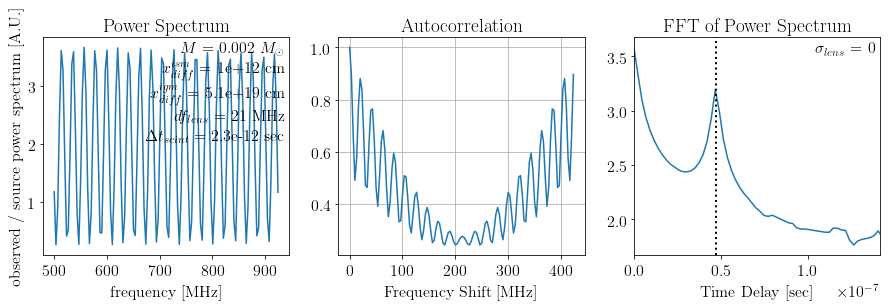

In [53]:
rnd.seed(110717)

# lens masses
# -----------
if batch_mode:
    rnd.seed()
#    M_table = np.array([1e-3, 0.01, 0.1, 1., 10.]) * u.Msun
#    x_diff_table = np.array([[1e9,np.nan], [1e10,np.nan], [1e11,np.nan], [1e12,np.nan]]) * u.cm # ISM only

    M_table = np.array([1e-3]) * u.Msun
    x_diff_table = np.array([[1e10,x_diff_igm_0]]) * u.cm # ISM and IGM

#    M_table = np.array([1e-4, 1e-3, 0.01, 0.1, 1., 10.]) * u.Msun # IGM only
#    x_diff_table = np.array([[np.nan,x_diff_igm_0]]) * u.cm
else:
    rnd.seed() # FIXME
    M_table = np.array([2e-3]) * u.Msun
    x_diff_table = np.array([[1e12,1000.*x_diff_igm_0]]) * u.cm

#    M_table = np.array([ 0.1 ]) * u.Msun
#    x_diff_table = np.array([[1e12,np.nan]]) * u.cm # ISM only
#    x_diff_table = np.array([[np.nan,x_diff_igm_0]]) * u.cm # IGM only


# Loop over all lens masses and x_diff values to be scanned
# ---------------------------------------------------------
run_summary = []
DS  = 1. * u. Gpc
DL  = 0.5 * u.Gpc
DLS = DS - DL
y   = 0.5
Dsc = 1. * u.kpc
zL  = dA_to_z(DL)
for x_diff_ism, x_diff_igm in x_diff_table:
    for M in M_table:
        print("Running simulation at M = {:7.4g} Msun, x_diff_ism = {:7.4g} cm".format(M/u.Msun, x_diff_ism/u.cm))
        print("---------------------------------------------------------------")
        run_summary.append(dict())
        run_summary[-1]['M']          = M
        run_summary[-1]['x_diff_ism'] = x_diff_ism
        run_summary[-1]['x_diff_igm'] = x_diff_igm
        run_summary[-1]['DS']         = DS
        run_summary[-1]['DL']         = DL
        run_summary[-1]['DLS']        = DLS
        run_summary[-1]['zL']         = zL
        run_summary[-1]['y']          = y
        run_summary[-1]['Dsc']        = Dsc
        theta_E = thE(DS, DL, M)
        rL = y * theta_E * DL
        
        # binning in space / wave number along the source screen
        n_x   = 1                 # number of samples in x on source screen
        x_max = 1e8 * u. cm       # binning of coordinates on source screen
        if n_x > 1:
            dx         = x_max / (n_x-1)
            x_range_in = xp.arange(-0.5*x_max, 0.5*x_max*(1+eps), dx) # range of discrete x samples on source screen
        else:
            dx         = 0.
            x_range_in = xp.array([ 0. ])

        # Determine frequency range to simulate as 5 times the width of the lensing wiggles
        dt_lens      = delta_t_lens(DS, DL, M, y)
        n_omega      = 128 # FIXME 128 or 512?
        omega_min    = 2*np.pi *  500*u.MHz
#        omega_max    = 2*np.pi * 1000*u.MHz
        omega_max    = 2*np.pi * (500*u.MHz + 20./dt_lens)
        omega_slices = 1  # FIXME FIXME 4
        print("frequency range = [{:g}, {:g}] MHz, {:d} * {:d} steps".format(
                omega_min/(2.*np.pi)/u.MHz, omega_max/(2.*np.pi)/u.MHz, omega_slices, n_omega//omega_slices))
        if n_omega > 1:
            domega         = (omega_max - omega_min) / (n_omega - 1)
            omega_range_in = xp.linspace(omega_min, omega_max, n_omega)
        else:
            omega_range_in = xp.array([ omega_min ])
        omega_0 = float(xp.mean(omega_range_in))
    
        # Generate signal template (at the source, before any scintillation or lensing)
#        def sig_spect(omega_range): # flat spectrum
#            return xp.where((omega_min*(1-eps) <= omega_range) & (omega_range <= omega_max*(1+eps)), 1.0, 0.0)
        def sig_spect(omega_range): # spectrum based on fit to a real GRB
            return xp.where((omega_min*(1-eps) <= omega_range) & (omega_range <= omega_max*(1+eps)), 
                            xp.sqrt(1e4*xp.exp(-omega_range/(2*np.pi * 100*u.MHz))), 0.0)
        spect_table_source = sig_spect(omega_range_in)
        spect_table_in = xp.concatenate(( xp.tile(0.j, ((n_x-1)//2, len(omega_range_in))),
                                          spect_table_source.reshape(1,len(omega_range_in)),
                                          xp.tile(0.j, (n_x-(n_x-1)//2-1, len(omega_range_in)))
                                       ))

        # Simulate signal after lensing and scintillation
        # (to save memory, split omega_range into smaller slices)
        # -------------------------------------------------------
        spect_table_out = np.array([])
        omega_range_out = np.array([])
        rnd_seed        = int(rnd.randint(2**32))
        for i in range(omega_slices):
            if i == 0:
                old_stdout = sys.stdout
            elif i == 1:
                sys.stdout = open(os.devnull, "w")
                               
            di          = n_omega // omega_slices
            omega_range = omega_range_in[i*di:(i+1)*di]
            spect_table = spect_table_in[:,i*di:(i+1)*di]
            
            # Re-initialize random number generator to the same state to make sure identical screens are generated
            rnd.seed(rnd_seed)
            
            # Fast test case
            if not batch_mode:
                # 1d, lensing only
#                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_out = evolve_to_screen_obs(screen_in, D=1.*u.Gpc, n_e_prop=0.03e-3/u.cm**3, DL=DL, M=M, rL=rL, omega_0=omega_0)
                
                # 2d, lensing only
#                spect_table = spect_table[None,:]
#                screen_in   = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_out  = evolve_to_screen_obs(screen_in, D=1.*u.Gpc, n_e_prop=0.03e-3/u.cm**3, DL=DL, M=M, rL=rL, omega_0=omega_0)
                
                # 1d, scintillation in the Milky Way (no lensing)
#                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_1   = evolve_to_screen_scint_1d(screen_in, D=1.*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_ism, omega_0=omega_0)
#                screen_out = evolve_to_screen_obs(     screen_1,  D=Dsc,      n_e_prop=0.03/u.cm**3, omega_0=omega_0)

                # 1d, lensing + scintillation in the Milky Way
#                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_1   = evolve_to_screen_scint_1d(screen_in, D=DS-Dsc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_ism, d=Dsc, \
#                                                       DL=DL, M=M, rL=rL, omega_0=omega_0, lensing="1d")
#                screen_out = evolve_to_screen_obs(     screen_1,  D=Dsc,    n_e_prop=0.03/u.cm**3, omega_0=omega_0)

                # 1d, lensing + scintillation in the IGM
                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
                screen_2   = evolve_to_screen_scint_1d(screen_in, D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=1*u.Gpc, omega_0=omega_0)
                screen_out = evolve_to_screen_obs(     screen_2,  D=0.75*u.Gpc, n_e_prop=0.03e-3/u.cm**3, DL=DL, M=M, rL=rL, omega_0=omega_0)

#                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_2   = evolve_to_screen_scint_1d(screen_in, D=0.75*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=1*u.Gpc, DL=DL-0.25*u.Gpc, M=M, rL=rL, omega_0=omega_0)
#                screen_out = evolve_to_screen_obs(     screen_2,  D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, omega_0=omega_0)

#                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_1   = evolve_to_screen_scint_1d(screen_in, D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=1*u.Gpc, omega_0=omega_0)
#                screen_2   = evolve_to_screen_scint_1d(screen_1,  D=0.5*u.Gpc,  n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=1*u.Gpc, DL=DL-0.25*u.Gpc, M=M, rL=rL, omega_0=omega_0)
#                screen_out = evolve_to_screen_obs(     screen_2,  D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, omega_0=omega_0)

                # 2d, lensing + scintillation in the IGM
#                spect_table = spect_table[None,:]
#                screen_in   = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_1    = evolve_to_screen_scint_2d(screen_in, D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=1*u.Gpc, omega_0=omega_0)
#                screen_out  = evolve_to_screen_obs(     screen_1,  D=0.75*u.Gpc, n_e_prop=0.03e-3/u.cm**3, DL=DL, M=M, rL=rL, omega_0=omega_0)

#                spect_table = spect_table[None,:]
#                screen_in   = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_1    = evolve_to_screen_scint_2d(screen_in, D=0.75*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=1*u.Gpc, DL=DL-0.25*u.Gpc, M=M, rL=rL, omega_0=omega_0)
#                screen_out  = evolve_to_screen_obs(     screen_1,  D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, omega_0=omega_0)
        
            else:
                # scintillation in the Milky Way ISM (no lensing)
#                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_1   = evolve_to_screen_scint_1d(screen_in, D=1.*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_ism, omega_0=omega_0)
#                screen_out = evolve_to_screen_obs(     screen_1,  D=Dsc,  n_e_prop=0.03/u.cm**3, omega_0=omega_0)

                # lensing + scintillation in the Milky Way ISM
#                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_1   = evolve_to_screen_scint_1d(screen_in, D=DS-Dsc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_ism, d=Dsc, \
#                                                       DL=DL, M=M, rL=rL, omega_0=omega_0, lensing="1d")
#                screen_out = evolve_to_screen_obs(     screen_1,  D=Dsc,    n_e_prop=0.03/u.cm**3, omega_0=omega_0)
        
                # lensing + scintillation in the IGM
#                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_2   = evolve_to_screen_scint_1d(screen_in, D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=1*u.Gpc, omega_0=omega_0)
#                screen_out = evolve_to_screen_obs(     screen_2,  D=0.75*u.Gpc, n_e_prop=0.03e-3/u.cm**3, DL=DL, M=M, rL=rL, omega_0=omega_0)

#                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_2   = evolve_to_screen_scint_1d(screen_in, D=0.75*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=1*u.Gpc, DL=DL-0.25*u.Gpc, M=M, rL=rL, omega_0=omega_0)
#                screen_out = evolve_to_screen_obs(     screen_2,  D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, omega_0=omega_0)       

                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
                screen_1   = evolve_to_screen_scint_1d(screen_in, D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=0.5*u.Gpc, omega_0=omega_0)
                screen_2   = evolve_to_screen_scint_1d(screen_1,  D=0.5*u.Gpc,  n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=0.5*u.Gpc, DL=DL-0.25*u.Gpc, M=M, rL=rL, omega_0=omega_0)
                screen_out = evolve_to_screen_obs(     screen_2,  D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, omega_0=omega_0)

#                spect_table = spect_table[None,:]
#                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_1   = evolve_to_screen_scint_2d(screen_in, D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=0.5*u.Gpc, omega_0=omega_0)
#                screen_2   = evolve_to_screen_scint_2d(screen_1,  D=0.5*u.Gpc,  n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=0.5*u.Gpc, DL=DL-0.25*u.Gpc, M=M, rL=rL, omega_0=omega_0)
#                screen_out = evolve_to_screen_obs(     screen_2,  D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, omega_0=omega_0)

                # lensing + scintillation in the IGM and Milky Way ISM
#                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_1   = evolve_to_screen_scint_1d(screen_in, D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=0.5*u.Gpc, omega_0=omega_0)
#                screen_2   = evolve_to_screen_scint_1d(screen_1,  D=0.5*u.Gpc,  n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=0.25*u.Gpc, DL=DL-0.25*u.Gpc, M=M, rL=rL, omega_0=omega_0)
#                screen_3   = evolve_to_screen_scint_1d(screen_2,  D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_ism, d=10.*u.kpc, omega_0=omega_0)
#                screen_out = evolve_to_screen_obs(     screen_3,  D=10*u.kpc,   n_e_prop=0.03/u.cm**3, omega_0=omega_0)

                # lensing + scintillation in the source ISM, IGM, and Milky Way ISM
                # reuse the same variable (screen_1) multiple times to release unused memory
#                screen_in  = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_1   = evolve_to_screen_scint_1d(screen_in, D=10.*u.kpc,  n_e_prop=0.03/u.cm**3,    x_diff=x_diff_ism, d=10.*u.kpc, omega_0=omega_0)
#                screen_1   = evolve_to_screen_scint_1d(screen_1,  D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=0.5*u.Gpc, omega_0=omega_0)
#                screen_1   = evolve_to_screen_scint_1d(screen_1,  D=0.5*u.Gpc,  n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_igm, d=0.25*u.Gpc, DL=DL-0.25*u.Gpc, M=M, rL=rL, omega_0=omega_0)
#                screen_1   = evolve_to_screen_scint_1d(screen_1,  D=0.25*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_ism, d=10.*u.kpc, omega_0=omega_0)
#                screen_out = evolve_to_screen_obs(     screen_1,  D=10*u.kpc,   n_e_prop=0.03/u.cm**3, omega_0=omega_0)

                # 2d test - remember to increase omega_slices
#                spect_table  = spect_table[None,:]
#                samples_file = "scint"+fname_suffix+"-samples.npy"
#                if i==0 and os.path.exists(samples_file):
#                    os.remove(samples_file)
#                screen_in   = Screen(x_range=x_range_in, omega_range=omega_range, spect_table=xp.array(spect_table), type='sum', DOsc=DS)
#                screen_1    = evolve_to_screen_scint_2d(screen_in, D=1.*u.Gpc, n_e_prop=0.03e-3/u.cm**3, x_diff=x_diff_ism, d=Dsc, DL=DL, M=M, rL=rL, omega_0=omega_0,
#                                                        samples_file=samples_file)
#                screen_out  = evolve_to_screen_obs(     screen_1,  D=Dsc,      n_e_prop=0.03/u.cm**3, omega_0=omega_0)

            # Normalization of final spectrum
            screen_out.spect_table *= DS

            # Move results from GPU to CPU if necessary and concatenate different omega chunks
            spect_table_out = np.concatenate((spect_table_out, nparray(screen_out.spect_table).flatten()))
            omega_range_out = np.concatenate((omega_range_out, nparray(screen_out.omega_range)))
            
            # Release GPU memory
            screen_in  = None
            screen_1   = None
            screen_2   = None
            screen_3   = None
            screen_4   = None
            screen_out = None
        # end loop over omega chunks
        
        if sys.stdout != old_stdout:
            sys.stdout.close()
            sys.stdout = old_stdout
#        spect_table = nparray(screen_out.spect_table).flatten()
#        omega_range = nparray(screen_out.omega_range)

        run_summary[-1]['omega_range']     = nparray(omega_range_out.flatten())
        run_summary[-1]['spect_table_out'] = nparray(spect_table_out.flatten())
        run_summary[-1]['spect_table_in']  = nparray(spect_table_in.flatten())
        run_summary[-1]['spect_table']     = run_summary[-1]['spect_table_out'] # for backwards compatibility
        
        # Analyze and plot results
        if not batch_mode:
            frb_analysis(run_summary[-1])
        print("")
        # end loop over M_table
# end loop over x_diff_table

# save summary to file
with open('scint{:s}.summary.dat'.format(fname_suffix), 'wb') as f:
    pickle.dump(run_summary, f)

###### Observations:

- increasing/decreasing n_scint by a factor 2 seems not to matter
- increasing n_coarse by a factor 2 does matter when using the large-memory usage fallback. This is understandable because in this case, dx_coars is no longer much smaller than x_F
- increasing n_coarse by a factor 2 does not matter outside the large-memory usage fallback region

Here, our acceptance criterion is that the modifications introduced by varying n_coarse or n_scint are smaller than the variations induced by statistical fluctuations (as judged by eye based on about 3 different random samples)

Notes / TODO items:
- Origin of the suppression at low frequencies?
- Fast oscillations at large $x_\text{diff}$: the fast oscillations that appeared in some of our plots (for instance at $M=10^{-3} M_\text{sun}$, $r_\text{diff}=10^{12} cm$) are in fact the lensing signal. Their oscillation length matches exactly the one expected from lensing. The longer-wavelength feature we saw as well has nothing to do with lensing.

In [ ]:
# This is where execution should stop when running in batch mode
if batch_mode != 0:
    sys.exit()

## Read output from batch runs

M=1.00e-03 Msun, x_diff=1.00e+10 cm: f_decorr=  20.04 MHz, sigma=0


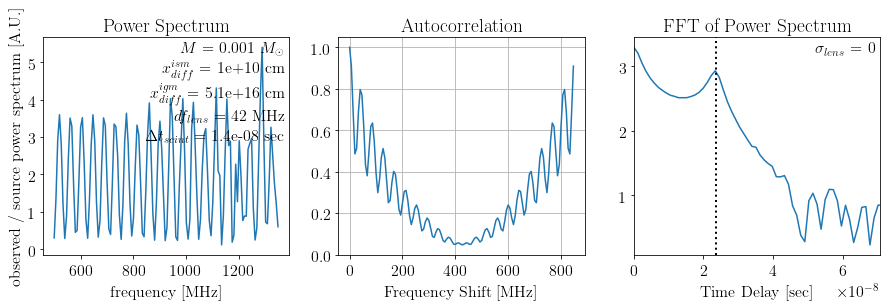

In [56]:
run_name = 'scint-igm2d'
with open(data_dir+'/'+run_name+'.summary.dat'.format(), 'rb') as f:
    run_summary = pickle.load(f)

M_table        = np.array([ x['M']          for x in run_summary ])
x_diff_table   = np.array([ x['x_diff_ism'] for x in run_summary ])
x_ref_table    = np.array([ 1.*u.kpc / (np.mean(x['omega_range']) * x['x_diff_ism']) for x in run_summary ])
dt_scint_table = x_ref_table**2 / (2. * 1.*u.kpc)

# Plot results
# ------------
dt_lens_table  = []
sigma_table    = []
for r in run_summary[:]:
#    frb_analysis(r)
    frb_analysis(r, plot_file='plots/'+run_name+'-Msun{:g}-xdiff{:g}.pdf'.format(r['M']/u.Msun, r['x_diff_ism']/u.cm))
    dt_lens_table.append(delta_t_lens(r['DS'], r['DL'], r['M'], r['y']))
    sigma_table.append(r['sigma_lens'])

In [127]:
# determine condition for coherent vs. incoherent scintillation screen (is the screen able to resolve the lens?)
def coherence_measure(run_summary, M_range, dt_scint_range):
    DS      = run_summary['DS']
    DL      = run_summary['DL']
    Dsc     = run_summary['Dsc']
    y       = run_summary['y']
    omega_0 = np.mean(run_summary['omega_range'])

    # determine the region in which the scintillation screen is able to resolve the Einstein radius
    # we use x_ref=min(d,D)*theta_s  and  dt_scint ~ x_ref**2 / (2 Dsc), see Sergey's notes, eq. (19)
    x_ref_table   = np.sqrt(2.*Dsc*dt_scint_range)
    theta_s_table = x_ref_table / (DL - Dsc)
    x_diff_table  = 1. / (omega_0 * theta_s_table)
    rE_table      = rE(DS, DL, M_range)
    thetaE_table  = rE_table / (DL - Dsc)

    # eq. (28) in Sergey's notes: requires that the projection of the Einstein radius onto the scintillation screen should be smaller than x_ref
    coherence_measure_1 = dt_scint_range[:,None] / ( 4.*np.pi**2 * DL**2 / (2.*rE(DS, DL, M_range[None,:])**2 * Dsc * omega_0**2) )

    # phase difference between the lensed images at x=x_ref, minus phase difference at x=0
#    coherence_measure_2 = omega_0 * np.abs( delta_t_lens(DS, DL, M_range[None,:], y - x_ref_table[:,None]/(thetaE_table[None,:]*DS)) 
#                                          - delta_t_lens(DS, DL, M_range[None,:], y))
    
    return coherence_measure_1

M_range        = 10.**np.arange(-4.,   1., 0.1) * u.Msun
dt_scint_range = 10.**np.arange(-15., -3., 0.1) * u.sec
coherence_measure_1 = coherence_measure(run_summary[0], M_range, dt_scint_range)

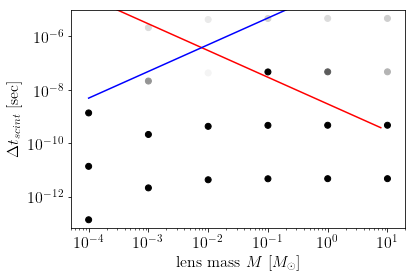

In [128]:
# summary plot
DS      = run_summary[0]['DS']
DL      = run_summary[0]['DL']
y       = run_summary[0]['y']
plt.scatter(M_table/u.Msun, dt_scint_table/u.sec, c=np.clip(sigma_table, 0, 7)/7., cmap='Greys')
plt.contour(*(np.meshgrid(M_range/u.Msun, dt_scint_range/u.sec)), coherence_measure_1, levels=[1.], colors=['red']) # coherence condition
#plt.contour(*(np.meshgrid(M_range/u.Msun, dt_scint_range/u.sec)), coherence_measure_2, levels=[1.], colors=['red'], linestyles=[':'])
plt.plot(M_range/u.Msun, np.array([ delta_t_lens(DS, DL, M, y) for M in M_range ])/u.sec, color='blue')                                                    # large vs. small decorrelation bandwidth
plt.plot()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lens mass $M$  [$M_\\odot$]')
plt.ylabel('$\Delta t_{{scint}}$ [sec]')
plt.xlim(min(0.5*M_table/u.Msun),       2.*max(M_table/u.Msun))
plt.ylim(min(0.5*dt_scint_table/u.sec), 2.*max(dt_scint_table/u.sec))
plt.show()

## Plots for Paper

### FRB transfer function

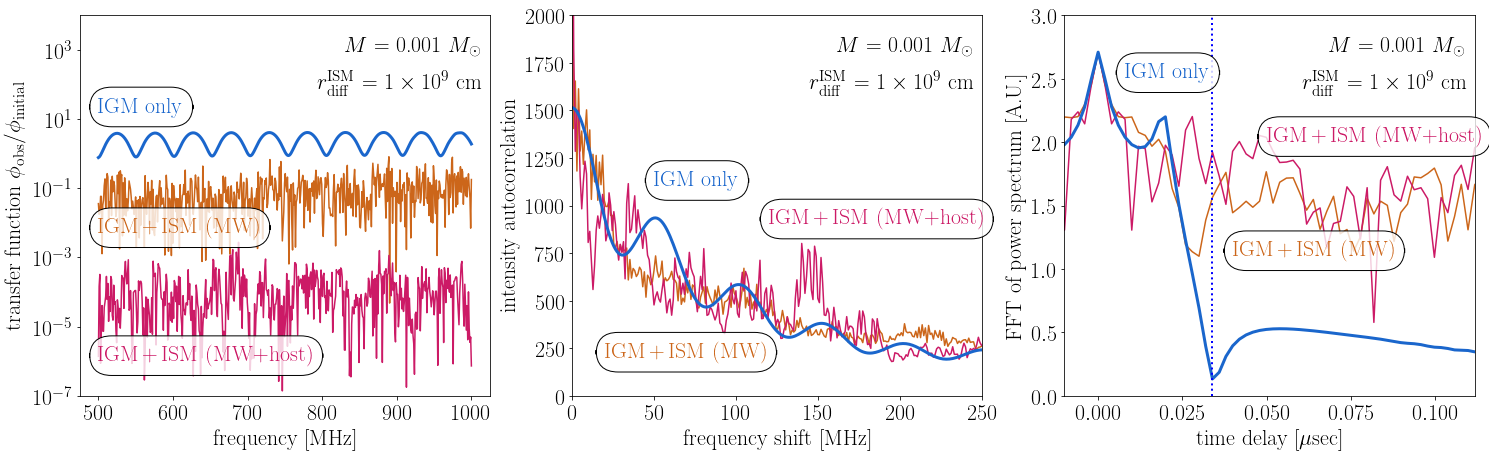

In [242]:
all_run_names     = [ 'scint-igm', 'scint-igmmwism', 'scint-igmism' ]
all_run_summaries = []
for run_name in all_run_names:
    with open(data_dir+'/'+run_name+'-summary.dat'.format(), 'rb') as f:
        all_run_summaries = all_run_summaries + pickle.load(f)

    #M_table        = np.array([ x['M']          for x in run_summary ])
    #x_diff_table   = np.array([ x['x_diff_ism'] for x in run_summary ])
    #x_ref_table    = np.array([ 1.*u.kpc / (np.mean(x['omega_range']) * x['x_diff_ism']) for x in run_summary ])
    #dt_scint_table = x_ref_table**2 / (2. * 1.*u.kpc)

# extract metadata for each run
M               = [ r['M']                         for r in all_run_summaries ]
DS              = [ r['DS']                        for r in all_run_summaries ]
DL              = [ r['DL']                        for r in all_run_summaries ]
DLS             = [ r['DLS']                       for r in all_run_summaries ]
y               = [ r['y']                         for r in all_run_summaries ]
omega_range     = [ r['omega_range']               for r in all_run_summaries ]
f_range         = [ r['omega_range'] / (2.*np.pi)  for r in all_run_summaries ]
spect_table_in  = [ r['spect_table_in'].flatten()  for r in all_run_summaries ]
spect_table_out = [ r['spect_table_out'].flatten() for r in all_run_summaries ]

# calculate expected lensing signal
omega_p         = np.sqrt(4 * np.pi * u.alpha_em * 0.03e-3/u.cm**3 / u.m_e)  # plasma frequency (for dispersion)
dt_lens         = [ delta_t_lens(DS[i], DL[i], M[i], y[i]) for i in range(len(f_range)) ] 
#dt_lens         = [ delta_t_lens2(0.5*u.Gpc, 0.25*u.Gpc, 1e-3*u.Msun, 1.) for i in range(len(f_range)) ]
#dt_lens         = [ delta_t_lens(0.5*u.Gpc, 0.25*u.Gpc, 1e-3*u.Msun, 1.) for i in range(len(f_range)) ] 
dt_lens_disp    = [ delta_t_lens(DS[i], DL[i], M[i], y[i]) / (1. - 0.5*omega_p**2/np.mean(omega_range[i])**2) for i in range(len(f_range)) ] 

    # calculate characteristic scintillation time delay
#    x_ref       = Dsc / (np.mean(omega_range) * x_diff_ism)
#    dt_scint    = x_ref**2 / (2. * Dsc)

# power spectrum
# --------------
plt.figure(figsize=(25,7))
plt.rc('font', size=22)
ax = plt.subplot(131)
ax.plot(f_range[0]/u.MHz, np.abs(spect_table_out[0]/spect_table_in[0])**2, color=(.1,.4,.8), ls='-', lw=3.)
ax.plot(f_range[1]/u.MHz, np.abs(spect_table_out[1]/spect_table_in[1])**2, color=(.8,.4,.1))
ax.plot(f_range[2]/u.MHz, np.abs(spect_table_out[2]/spect_table_in[1])**2, color=(.8,.1,.4))
ax.set_xlabel("frequency [MHz]")
ax.set_ylabel("transfer function $\\phi_{\\rm obs} / \\phi_{\\rm initial}$")
#ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_ylim(1e-7, 1e4)

my_box = dict(boxstyle='round, rounding_size=1, pad=0.4', fc=(1,1,1,.8), ec='black')
ax.text(500, 15,     r"IGM only",              color=(.1,.4,.8), bbox=my_box)
ax.text(500, 0.5e-2, r"IGM\,+\,ISM (MW)",      color=(.8,.4,.1), bbox=my_box)
ax.text(500, 1e-6,   r"IGM\,+\,ISM (MW+host)", color=(.8,.1,.4), bbox=my_box)
ax.annotate(r"$M$ = {:5.2g} $M_\odot$".format(M[0]/u.Msun),
            (0.98,0.94), xycoords='axes fraction', ha='right', va='top')
ax.annotate(r'$r_\text{{diff}}^\text{{ISM}}$ = \num{{{:5.2g}}} cm'.format(all_run_summaries[0]['x_diff_ism']/u.cm),
            (0.98,0.84), xycoords='axes fraction', ha='right', va='top')
#    if not np.isnan(x_diff_igm):
#        my_labels = my_labels + "$x_{{diff}}^{{igm}}$ = {:5.2g} cm\n".format(x_diff_igm/u.cm)
#    my_labels = my_labels + "$df_{{lens}}$ = {:5.2g} MHz\n".format(1./dt_lens / u.MHz)
#    my_labels = my_labels + "$\\Delta t_{{scint}}$ = {:5.2g} sec".format(dt_scint / u.sec)
#    ax.annotate(my_labels, (0.98,0.98), xycoords='axes fraction', ha='right', va='top')
    
# autocorrelation
# ---------------
ax           = plt.subplot(132)
f_range_corr = [ f_range[i] - f_range[i][0] for i in range(len(f_range)) ]
spect_corr   = [ fft.ifft( np.abs(fft.fft(np.abs(spect_table_out[i])**2)) ** 2 ) / np.mean(np.abs(spect_table_out[i])**2)**2 for i in range(len(f_range)) ]
#spect_corr   = [ fft.ifft( np.abs(fft.fft(spect_table_out[i])) ** 2 ) / np.mean(np.abs(spect_table_out[i]))**2 for i in range(len(f_range)) ]
ax.plot(f_range_corr[1]/u.MHz, spect_corr[1], color=(.8,.4,.1))
ax.plot(f_range_corr[2]/u.MHz, spect_corr[2], color=(.8,.1,.4))
ax.plot(f_range_corr[0]/u.MHz, spect_corr[0], color=(.1,.4,.8), ls='-', lw=3.)
ax.set_xlim(0., np.mean(f_range_corr[0]/u.MHz))
ax.set_ylim(0.,2000.)
ax.set_xlabel("frequency shift [MHz]")
ax.set_ylabel("intensity autocorrelation")
#ax.grid(which='both')

ax.text( 50, 1100, r"IGM only",              color=(.1,.4,.8), bbox=my_box)
ax.text( 20,  200, r"IGM\,+\,ISM (MW)",      color=(.8,.4,.1), bbox=my_box)
ax.text(120,  900, r"IGM\,+\,ISM (MW+host)", color=(.8,.1,.4), bbox=my_box)
ax.annotate(r"$M$ = {:5.2g} $M_\odot$".format(M[0]/u.Msun),
            (0.98,0.94), xycoords='axes fraction', ha='right', va='top')
ax.annotate(r'$r_\text{{diff}}^\text{{ISM}}$ = \num{{{:5.2g}}} cm'.format(all_run_summaries[0]['x_diff_ism']/u.cm),
            (0.98,0.84), xycoords='axes fraction', ha='right', va='top')

# FFT of power spectrum
# ---------------------
ax          = plt.subplot(133)
domega      = [ (omega_range[i][-1] - omega_range[i][0]) / (len(omega_range[i]) - 1) for i in range(len(f_range)) ]
dt_fft      = [ 2.*np.pi / (domega[i] * len(omega_range[i]))                         for i in range(len(f_range)) ]
t_range_fft = [ np.arange(-np.pi/domega[i], np.pi*(1-eps)/domega[i], dt_fft[i])      for i in range(len(f_range)) ]    
pspect_fft  = [ np.roll( np.abs(fft.fft(np.abs(spect_table_out[i])**2)) / np.mean(np.abs(spect_table_out[i])**2),
                                                            len(t_range_fft[i])//2 ) for i in range(len(f_range)) ]
#pspect_fft  = [ np.roll( np.abs(fft.fft(np.abs(spect_table_out[i])**2))
#                         / np.mean(np.abs(spect_table_out[i])**2), len(t_range_fft[i])//2 ) for i in range(len(f_range)) ]
ax.plot(t_range_fft[1]/(1e-6*u.sec), np.log10(pspect_fft[1]), color=(.8,.4,.1))
ax.plot(t_range_fft[2]/(1e-6*u.sec), np.log10(pspect_fft[2]), color=(.8,.1,.4))
ax.plot(t_range_fft[0]/(1e-6*u.sec), np.log10(pspect_fft[0]), color=(.1,.4,.8), ls='-', lw=3.)     
        # log or no log? FIXME FIXME FIXME
ax.set_xlabel(r"time delay [$\mu$sec]")
ax.set_ylabel(r"FFT of power spectrum [A.U.]")
ax.set_xlim(-0.01, t_range_fft[0][-200]/(1e-6*u.sec))
ax.set_ylim(0.,3.)

ax.text(0.008, 2.5, r"IGM only",              color=(.1,.4,.8), bbox=my_box)
ax.text(0.04,  1.1, r"IGM\,+\,ISM (MW)",      color=(.8,.4,.1), bbox=my_box)
ax.text(0.05,  2.0, r"IGM\,+\,ISM (MW+host)", color=(.8,.1,.4), bbox=my_box)
ax.annotate(r"$M$ = {:5.2g} $M_\odot$".format(M[0]/u.Msun),
            (0.98,0.94), xycoords='axes fraction', ha='right', va='top')
ax.annotate(r'$r_\text{{diff}}^\text{{ISM}}$ = \num{{{:5.2g}}} cm'.format(all_run_summaries[0]['x_diff_ism']/u.cm),
            (0.98,0.84), xycoords='axes fraction', ha='right', va='top')
#ax.axvline(x=(dt_lens[0] - 0*dt_fft[0]) / (1e-6*u.sec), linestyle=':', color='black', linewidth=2)
ax.axvline(x=delta_t_lens(1*u.Gpc, 0.5*u.Gpc, 1e-3*u.Msun,
           1.*rE(0.5*u.Gpc,0.25*u.Gpc,1e-3*u.Msun) / rE(1.*u.Gpc,0.5*u.Gpc,1e-3*u.Msun)) \
           / (1e-6*u.sec), linestyle=':', color='blue', linewidth=2)

plt.show()
plt.close()